In [450]:
import pandas as pd
from pathlib import Path
from loguru import logger
import seaborn as sns
import numpy as np
import seaborn as sns
import matplotlib.cm as cm
from matplotlib.colors import to_hex
import matplotlib.pyplot as plt

In [451]:
data_dir = Path("mhc")
df = pd.read_csv("./mhc_data.csv")
df.head()

,species,mhc,peptide_length,sequence,inequality,meas,job_name
0,human,HLA-A*02:01,9,YLYPWSLGL,=,1.0,mhc_0
1,human,HLA-A*02:01,9,YIYTRSFQM,=,1.0,mhc_1
2,human,HLA-A*02:01,9,YLAGWGFVV,=,1.0,mhc_2
3,human,HLA-A*02:01,9,QMDGAILVV,=,1.0,mhc_3
4,human,HLA-A*02:01,9,VLMGGVPGV,=,1.0,mhc_4


In [452]:
confidence_df = pd.read_csv("./results/af3_confidence.csv")
df.rename(columns={"job_name": "job_id"}, inplace=True)
df = pd.merge(df, confidence_df, on=["job_id"], how="right")

missing_data_df = df[df.isnull().any(axis=1)]
logger.info("Below are examples of rows with missing values after merging:")
logger.info(missing_data_df)

2025-03-27 19:30:22.695 | INFO     | __main__:<module>:6 - Below are examples of rows with missing values after merging:
2025-03-27 19:30:22.697 | INFO     | __main__:<module>:7 - Empty DataFrame
Columns: [species, mhc, peptide_length, sequence, inequality, meas, job_id, model_name, seed_id, sample_id, original_iptm, original_ptm, actifptm, iptm, ptm, confidence_score, original_confidence_score, ranking_score, original_ranking_score]
Index: []


In [453]:
deltag_df = pd.read_csv("./results/af3_deltag.csv")
df = pd.merge(df, deltag_df, on=["job_id", "seed_id", "sample_id", "model_name"], how="left")

missing_data_df = df[df.isnull().any(axis=1)]
logger.info("Below are examples of rows with missing values after merging:")
logger.info(missing_data_df)

2025-03-27 19:30:22.734 | INFO     | __main__:<module>:5 - Below are examples of rows with missing values after merging:
2025-03-27 19:30:22.736 | INFO     | __main__:<module>:6 - Empty DataFrame
Columns: [species, mhc, peptide_length, sequence, inequality, meas, job_id, model_name, seed_id, sample_id, original_iptm, original_ptm, actifptm, iptm, ptm, confidence_score, original_confidence_score, ranking_score, original_ranking_score, dG_separated, dG_cross, sc_value, nres_all, nres_int, total_score, binding_energy]
Index: []

[0 rows x 26 columns]


In [454]:
iASA_df = pd.read_csv("./results/af3_iASA.csv")
df = pd.merge(df, iASA_df, on=["job_id", "seed_id", "sample_id", "model_name"], how="left")

missing_data_df = df[df.isnull().any(axis=1)]
logger.info("Below are examples of rows with missing values after merging:")
logger.info(missing_data_df)

2025-03-27 19:30:22.771 | INFO     | __main__:<module>:5 - Below are examples of rows with missing values after merging:
2025-03-27 19:30:22.773 | INFO     | __main__:<module>:6 - Empty DataFrame
Columns: [species, mhc, peptide_length, sequence, inequality, meas, job_id, model_name, seed_id, sample_id, original_iptm, original_ptm, actifptm, iptm, ptm, confidence_score, original_confidence_score, ranking_score, original_ranking_score, dG_separated, dG_cross, sc_value, nres_all, nres_int, total_score, binding_energy, iASA, iASA%, sasa_peptide, sasa_protein, sasa_complex]
Index: []

[0 rows x 31 columns]


In [455]:
df["meas_log"] = np.log(df["meas"])
df["dG_cross_iASA"] = df["dG_cross"] / df["iASA%"]

In [456]:
def rerank_score(
    df: pd.DataFrame, metric: str, ascending: bool = False, mode: str = "global"
) -> pd.DataFrame:
    df = df.copy()
    rank_methods = "first"
    if mode == "global":
        # Global rank: Rank within each (job_name, model_name) group
        df["global_rank_{}".format(metric)] = (
            df.groupby(["job_id"])[metric]
            .rank(
                method=rank_methods, ascending=ascending
            )  # Use 'first' for deterministic tie-breaking
            .astype(int)
        )
    elif mode == "local":
        df["local_rank_{}".format(metric)] = (
            df.groupby(["job_id", "seed_id"])[metric]
            .rank(
                method=rank_methods, ascending=ascending
            )  # Use 'first' to ensure ties are broken deterministically
            .astype(int)  # Convert to integers for cleaner output
        )
        df = df[df["local_rank_{}".format(metric)] <= 1]

        df["global_rank_{}".format(metric)] = (
            df.groupby(["job_id"])[metric]
            .rank(
                method=rank_methods, ascending=ascending
            )  # Use 'first' for deterministic tie-breaking
            .astype(int)
        )
        df.drop(columns=["local_rank_{}".format(metric)], inplace=True)
    return df

In [457]:
# df = rerank_score(df, metric='dG_cross', ascending=True)
# df = df[df["global_rank_dG_cross"] <= 1]

# df = rerank_score(df, metric='ranking_score', ascending=False)
# df = df[df["global_rank_ranking_score"] <= 1]

df = rerank_score(df, metric='original_ranking_score', ascending=False)
df = df[df["global_rank_original_ranking_score"] <= 1]

# df = rerank_score(df, metric='original_iptm', ascending=False)
# df = df[df["global_rank_original_iptm"] <= 1]

# df = rerank_score(df, metric='actifptm', ascending=False)
# df = df[df["global_rank_actifptm"] <= 1]

# df = rerank_score(df, metric='original_confidence_score', ascending=False)
# df = df[df["global_rank_original_confidence_score"] <= 1]

In [458]:
df.to_csv("./results/results.csv", index=False)

In [459]:
# # 先求每个 job_id 的 iptm 平均值
# iptm_mean = df.groupby("job_id")["iptm"].mean()

# # 找出均值 > 0.9 的 job_id
# selected_job_ids = iptm_mean[iptm_mean > 0.9].index

# # 在原始 df 中筛选这些 job_id 的所有行
# df = df[df["job_id"].isin(selected_job_ids)].reset_index(drop=True)

/tmp/ipykernel_2393696/585133909.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=new_labels, y=corr_series.values, palette="Set2", width=0.6)


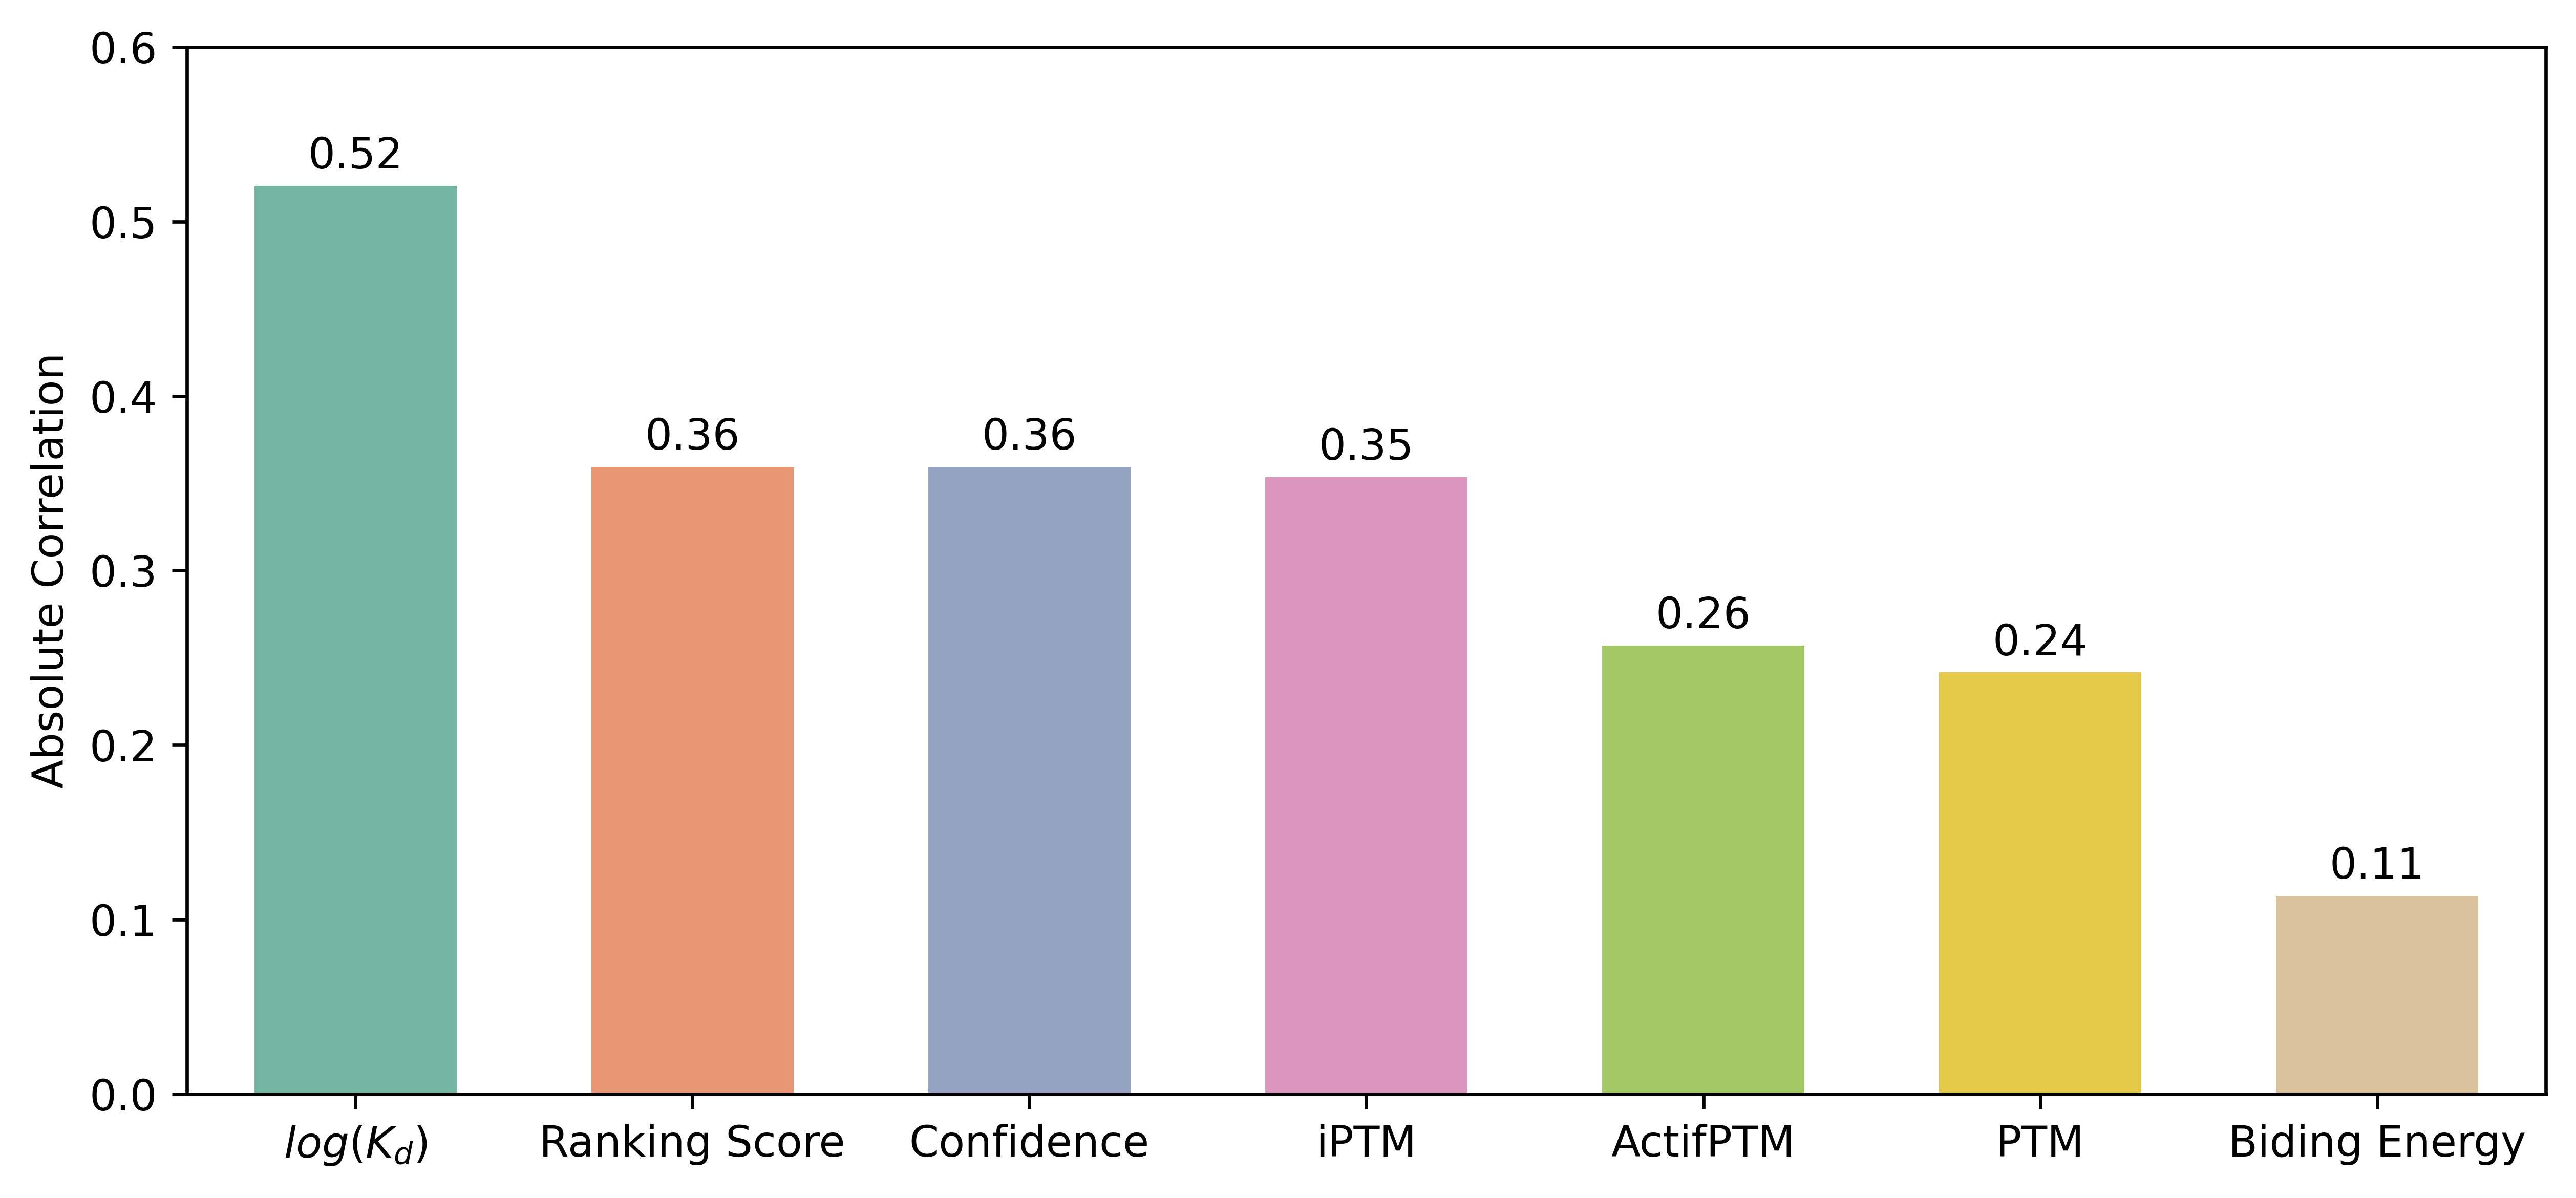

In [460]:
selected_columns = [
    "meas", "meas_log", "original_iptm", "actifptm", "original_ptm", 
    "original_confidence_score", "original_ranking_score", "dG_cross"
]

rename_map = {
    "meas": "$K_d$",
    "meas_log": "$log (K_d)$",
    "original_iptm": "iPTM",
    "actifptm": "ActifPTM",
    "original_ptm": "PTM",
    "original_confidence_score": "Confidence",
    "original_ranking_score": "Ranking Score",
    "dG_cross": "Biding Energy"
}

# 计算 Pearson 相关性
corr_series = df[selected_columns].corr(method="pearson")["meas"].drop("meas").abs()
corr_series = corr_series.sort_values(ascending=False)
new_labels = [rename_map.get(label, label) for label in corr_series.index]

# 绘图
plt.figure(figsize=(8.5, 4), dpi=600)
ax = sns.barplot(x=new_labels, y=corr_series.values, palette="Set2", width=0.6)

# 添加柱子上的数值标签
for container in ax.containers:
    ax.bar_label(container, fmt="%.2f", label_type="edge", padding=2)

plt.ylabel("Absolute Correlation")
plt.xlabel("")
plt.ylim(0, 0.6)
# plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

/tmp/ipykernel_2393696/542487244.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=new_labels, y=corr_series.values, palette="Set2", width=0.6)


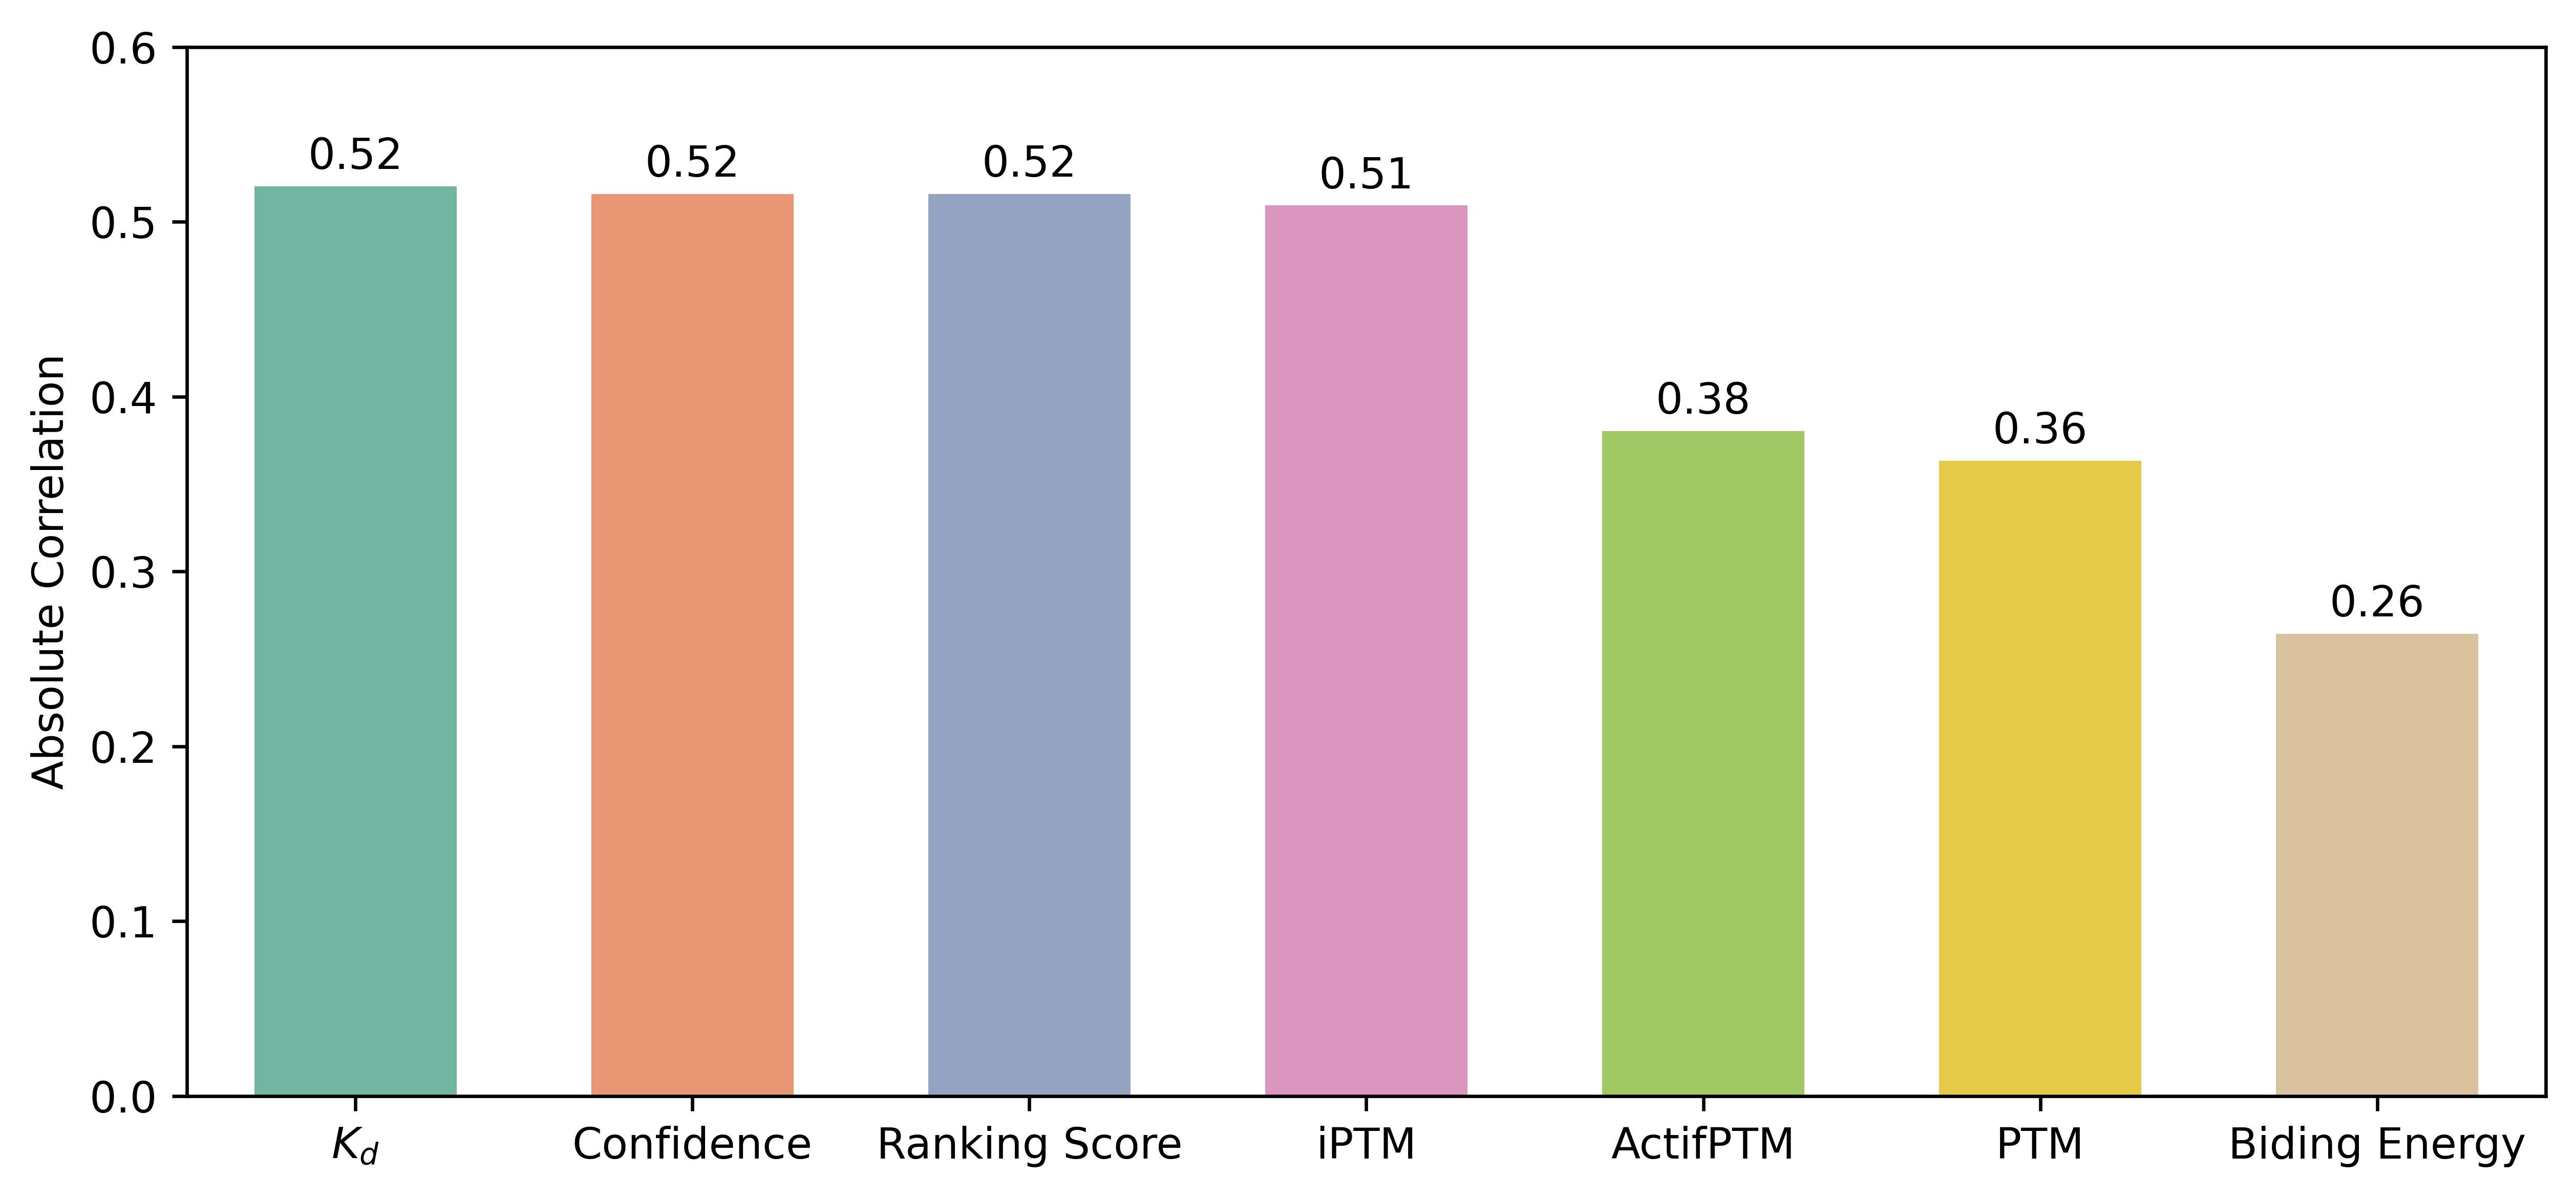

In [461]:
# 计算 Pearson 相关性
corr_series = df[selected_columns].corr(method="pearson")["meas_log"].drop("meas_log").abs()
corr_series = corr_series.sort_values(ascending=False)
new_labels = [rename_map.get(label, label) for label in corr_series.index]

# 绘图
plt.figure(figsize=(8.5, 4), dpi=600)
ax = sns.barplot(x=new_labels, y=corr_series.values, palette="Set2", width=0.6)

# 添加柱子上的数值标签
for container in ax.containers:
    ax.bar_label(container, fmt="%.2f", label_type="edge", padding=2)

plt.ylabel("Absolute Correlation")
plt.xlabel("")
plt.ylim(0, 0.6)
# plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

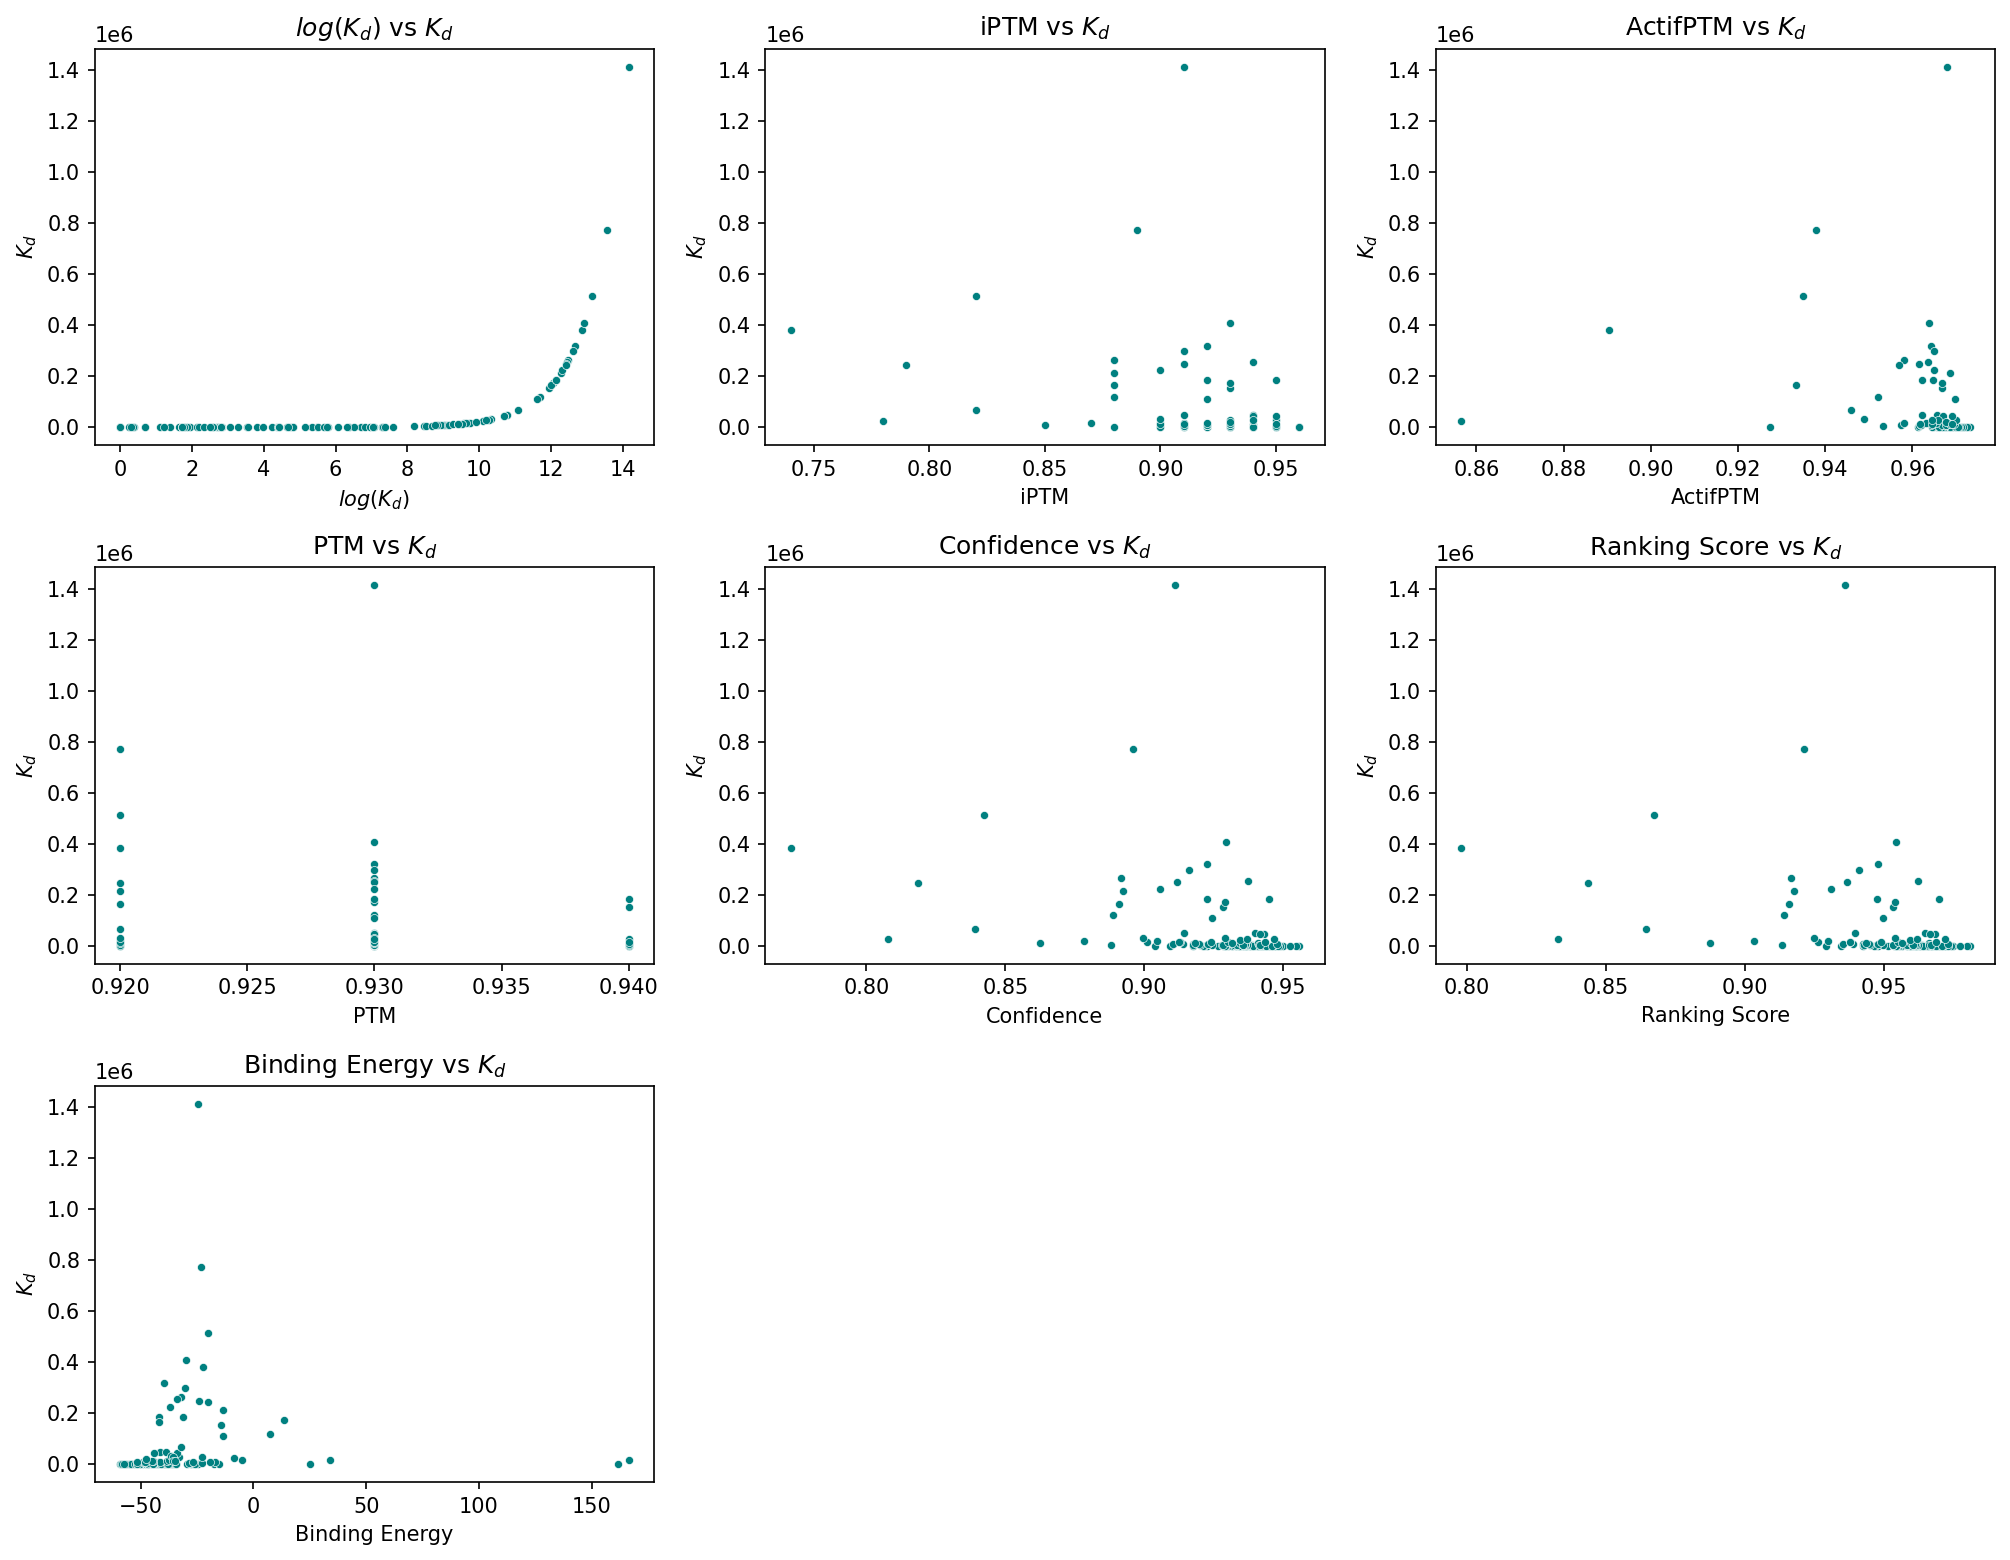

In [462]:
import matplotlib.pyplot as plt
import seaborn as sns

selected_columns = [
    "meas", "meas_log", "original_iptm", "actifptm", "original_ptm", 
    "original_confidence_score", "original_ranking_score", "dG_cross"
]

rename_map = {
    "meas": "$K_d$",
    "meas_log": "$log (K_d)$",
    "original_iptm": "iPTM",
    "actifptm": "ActifPTM",
    "original_ptm": "PTM",
    "original_confidence_score": "Confidence",
    "original_ranking_score": "Ranking Score",
    "dG_cross": "Binding Energy"
}

# 设定要对比的目标列
target_column = "meas"
other_columns = [col for col in selected_columns if col != target_column]

# 可视化：多个子图
n_cols = 3
n_rows = -(-len(other_columns) // n_cols)  # 向上取整
fig, axes = plt.subplots(n_rows, n_cols, figsize=(4.5 * n_cols, 3.5 * n_rows), dpi=150)

axes = axes.flatten()
for i, col in enumerate(other_columns):
    ax = axes[i]
    sns.scatterplot(data=df, x=col, y=target_column, ax=ax, color="teal", s=15)
    ax.set_xlabel(rename_map.get(col, col))
    ax.set_ylabel(rename_map.get(target_column, target_column))
    ax.set_title(f"{rename_map.get(col, col)} vs {rename_map.get(target_column)}")

# 删除多余子图
for j in range(len(other_columns), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

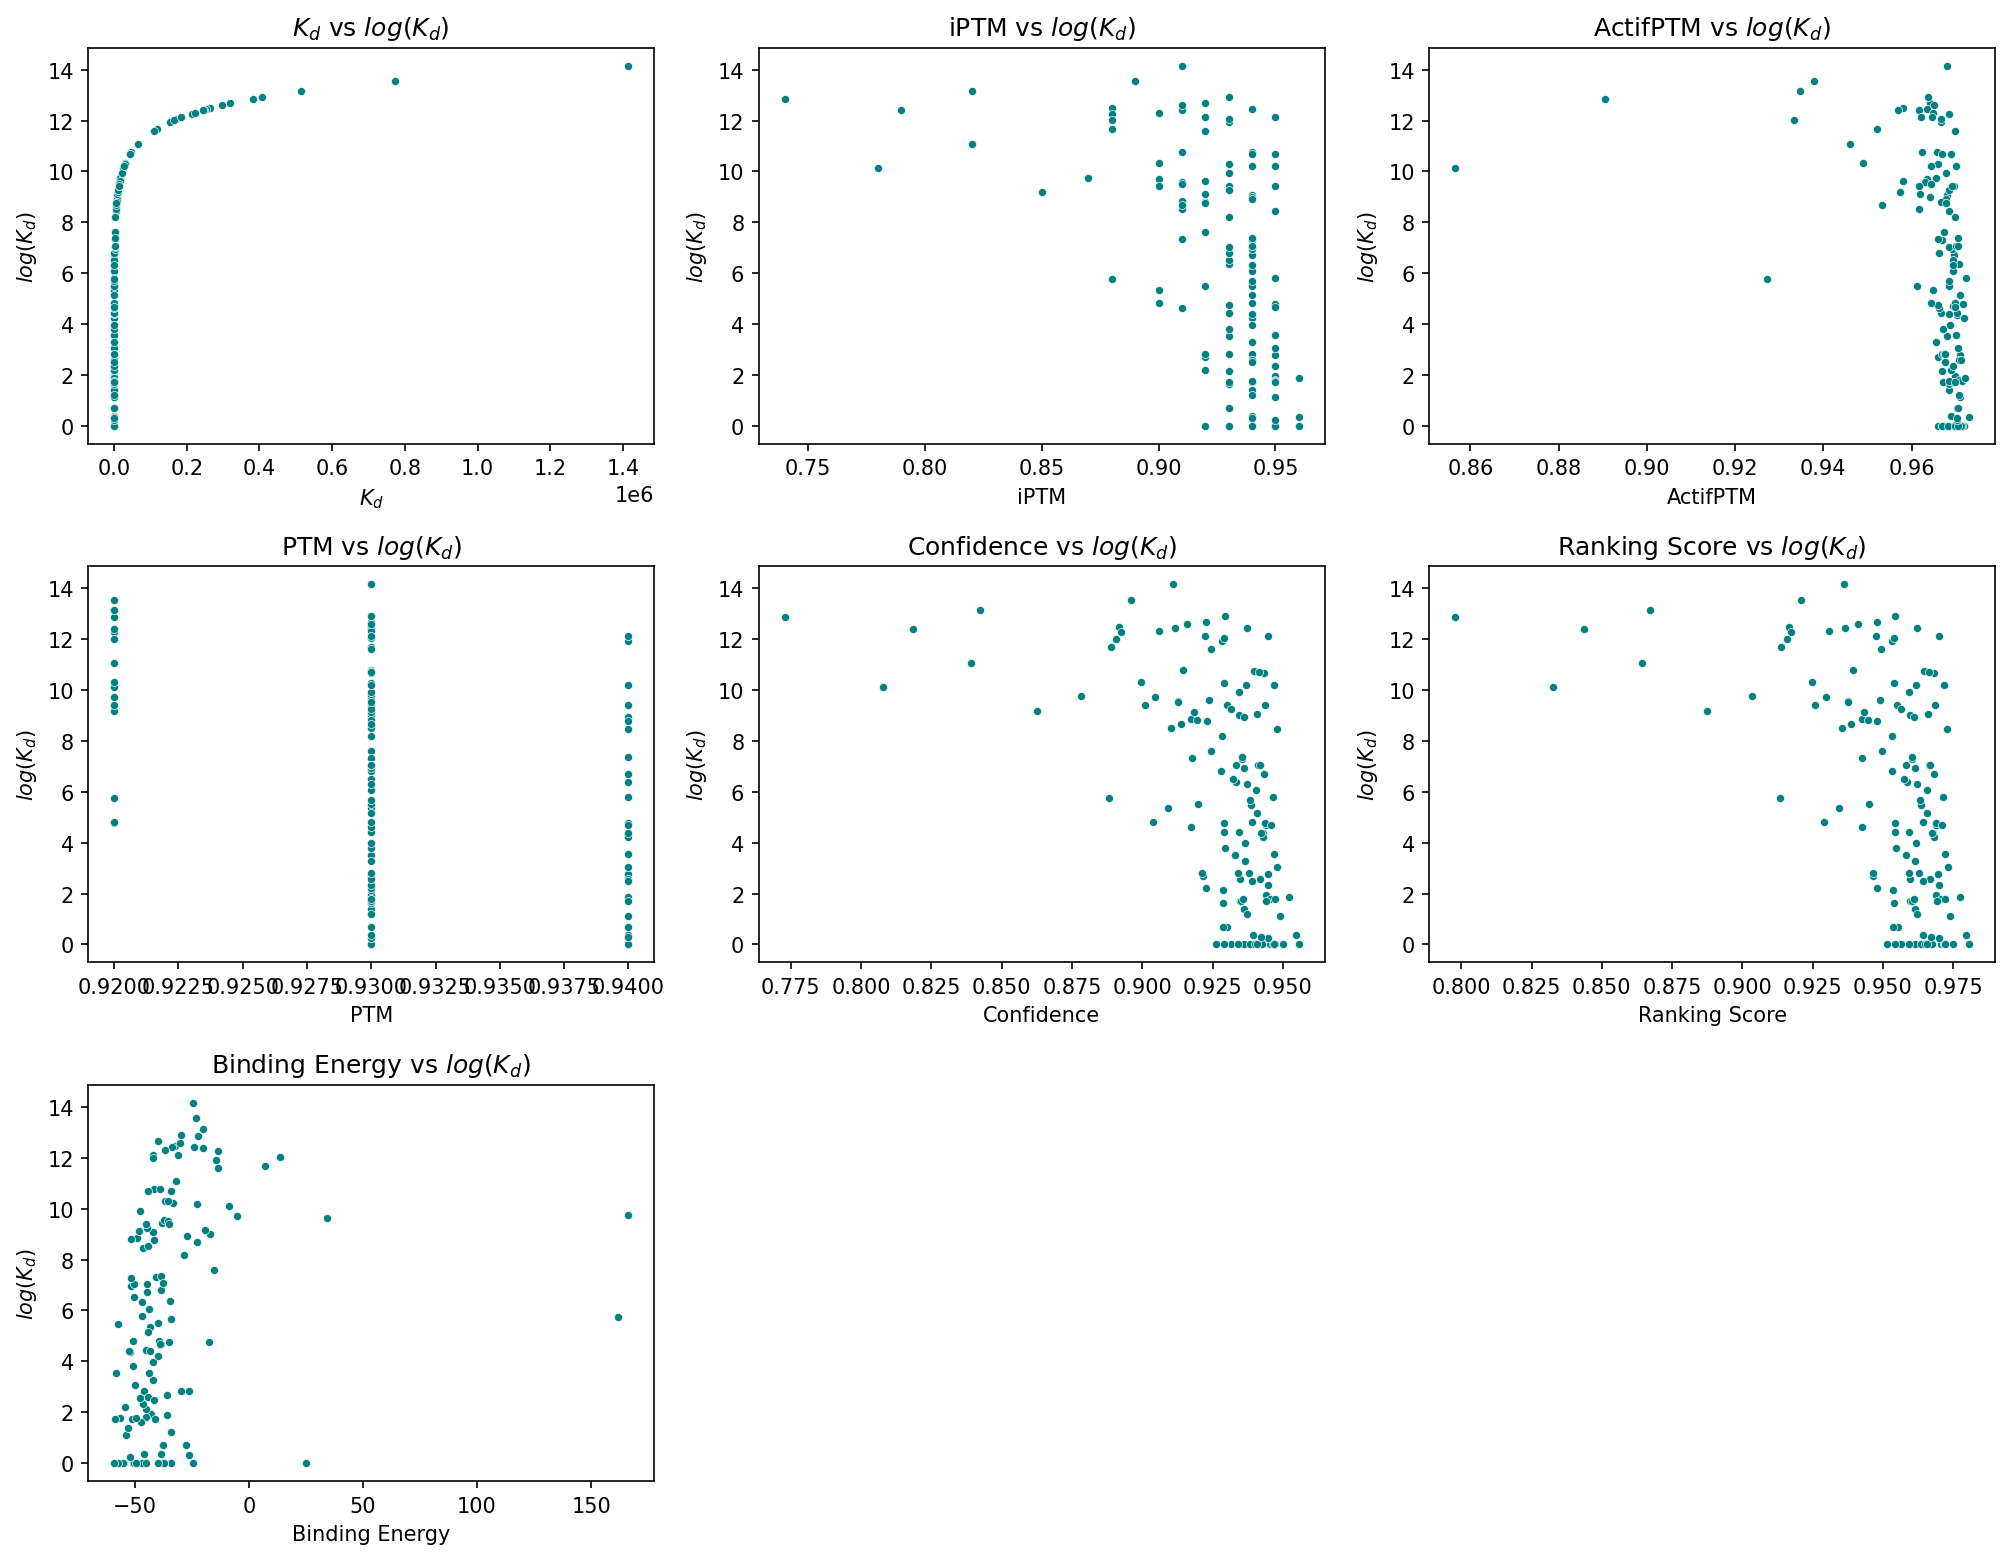

In [463]:
import matplotlib.pyplot as plt
import seaborn as sns

selected_columns = [
    "meas", "meas_log", "original_iptm", "actifptm", "original_ptm", 
    "original_confidence_score", "original_ranking_score", "dG_cross"
]

rename_map = {
    "meas": "$K_d$",
    "meas_log": "$log (K_d)$",
    "original_iptm": "iPTM",
    "actifptm": "ActifPTM",
    "original_ptm": "PTM",
    "original_confidence_score": "Confidence",
    "original_ranking_score": "Ranking Score",
    "dG_cross": "Binding Energy"
}

# 设定要对比的目标列
target_column = "meas_log"
other_columns = [col for col in selected_columns if col != target_column]

# 可视化：多个子图
n_cols = 3
n_rows = -(-len(other_columns) // n_cols)  # 向上取整
fig, axes = plt.subplots(n_rows, n_cols, figsize=(4.5 * n_cols, 3.5 * n_rows), dpi=150)

axes = axes.flatten()
for i, col in enumerate(other_columns):
    ax = axes[i]
    sns.scatterplot(data=df, x=col, y=target_column, ax=ax, color="teal", s=15)
    ax.set_xlabel(rename_map.get(col, col))
    ax.set_ylabel(rename_map.get(target_column, target_column))
    ax.set_title(f"{rename_map.get(col, col)} vs {rename_map.get(target_column)}")

# 删除多余子图
for j in range(len(other_columns), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

/tmp/ipykernel_2393696/470234385.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=new_labels, y=corr_series.values, palette="Set2", width=0.6)


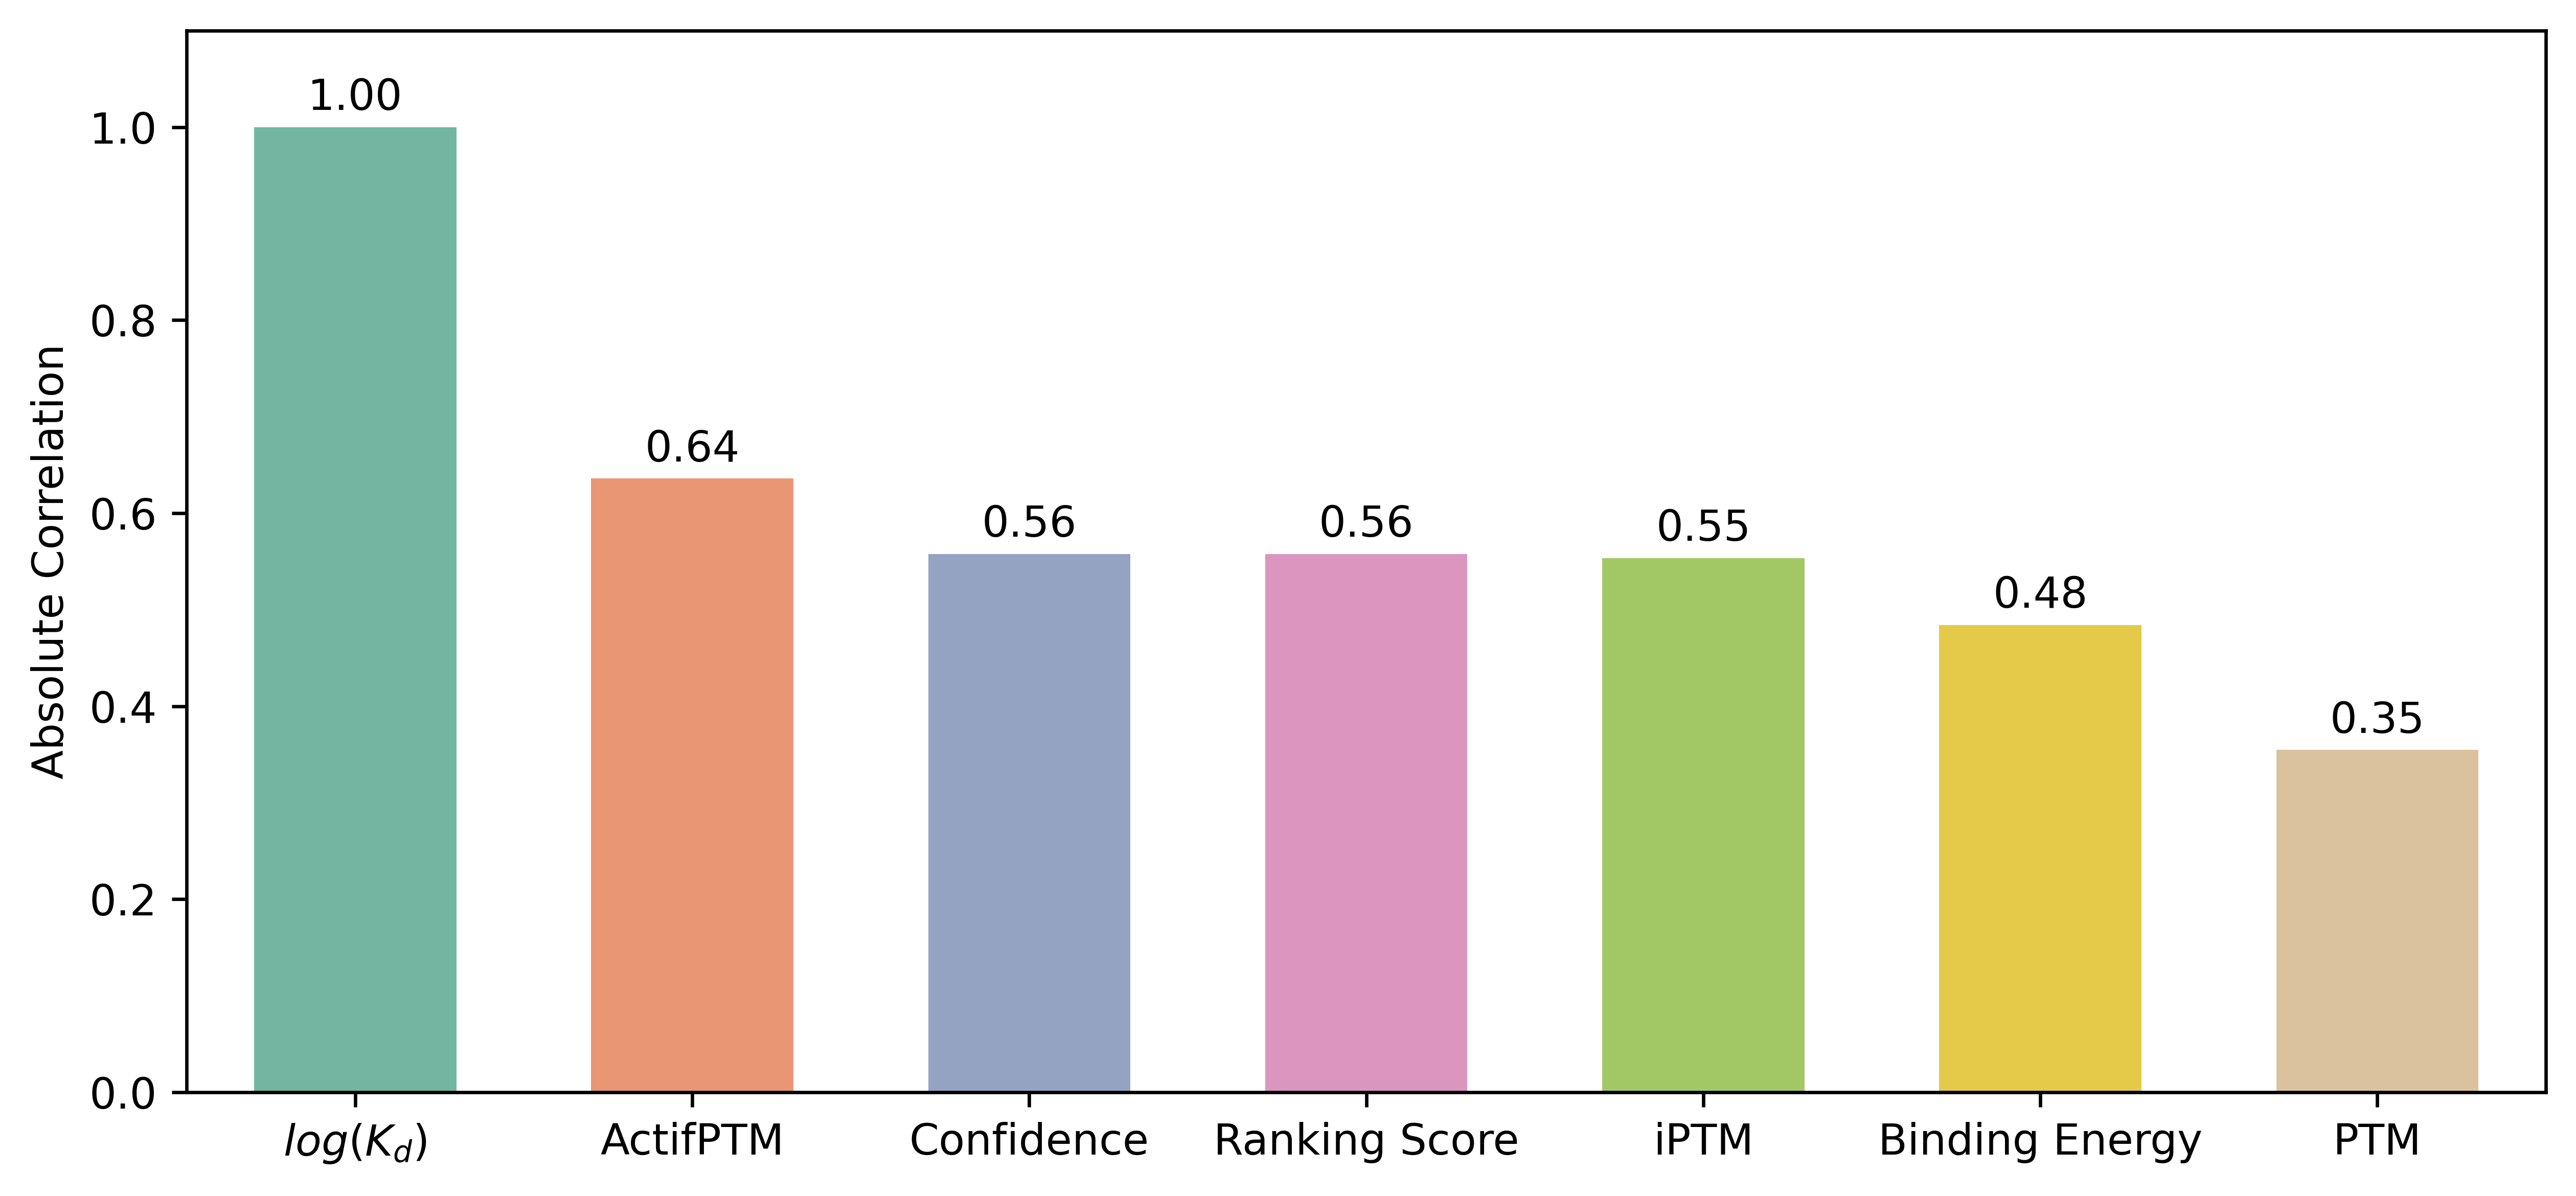

In [464]:
# 计算 Pearson 相关性
corr_series = df[selected_columns].corr(method="spearman")["meas"].drop("meas").abs()
corr_series = corr_series.sort_values(ascending=False)
new_labels = [rename_map.get(label, label) for label in corr_series.index]

# 绘图
plt.figure(figsize=(8.5, 4), dpi=600)
ax = sns.barplot(x=new_labels, y=corr_series.values, palette="Set2", width=0.6)

# 添加柱子上的数值标签
for container in ax.containers:
    ax.bar_label(container, fmt="%.2f", label_type="edge", padding=2)

plt.ylabel("Absolute Correlation")
plt.xlabel("")
plt.ylim(0, 1.1)
# plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

/tmp/ipykernel_2393696/2488470752.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=new_labels, y=corr_series.values, palette="Set2", width=0.6)


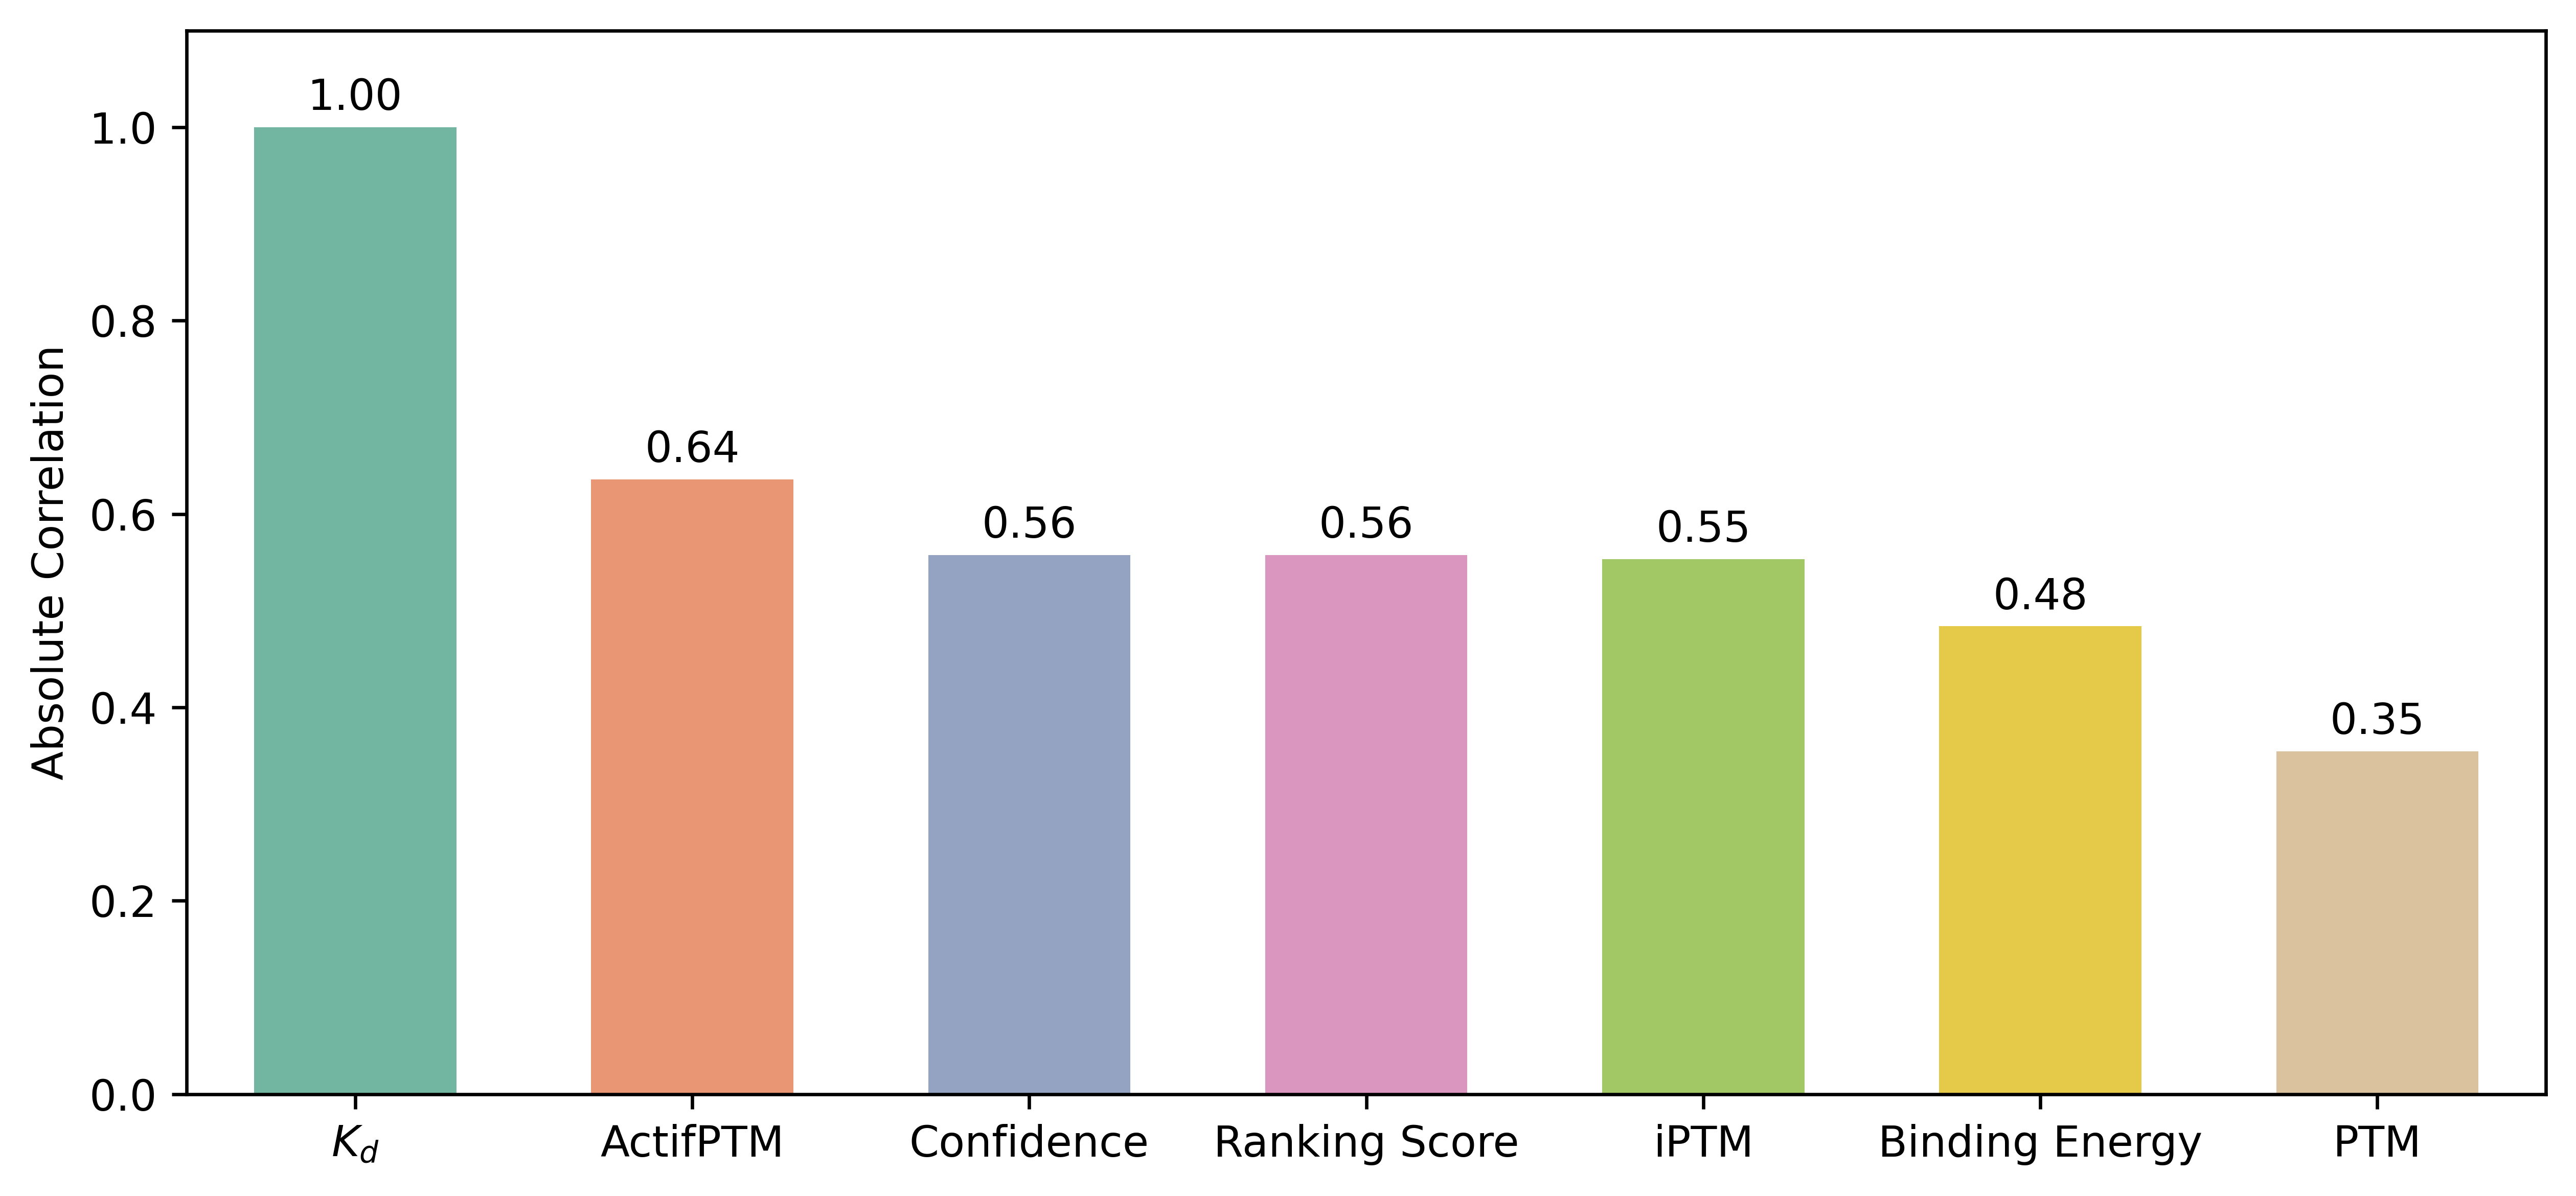

In [465]:
# 计算 Pearson 相关性
corr_series = df[selected_columns].corr(method="spearman")["meas_log"].drop("meas_log").abs()
corr_series = corr_series.sort_values(ascending=False)
new_labels = [rename_map.get(label, label) for label in corr_series.index]

# 绘图
plt.figure(figsize=(8.5, 4), dpi=600)
ax = sns.barplot(x=new_labels, y=corr_series.values, palette="Set2", width=0.6)

# 添加柱子上的数值标签
for container in ax.containers:
    ax.bar_label(container, fmt="%.2f", label_type="edge", padding=2)

plt.ylabel("Absolute Correlation")
plt.xlabel("")
plt.ylim(0, 1.1)
# plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

/tmp/ipykernel_2393696/697885161.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=labels, y=values, palette="Set3", width=0.6)


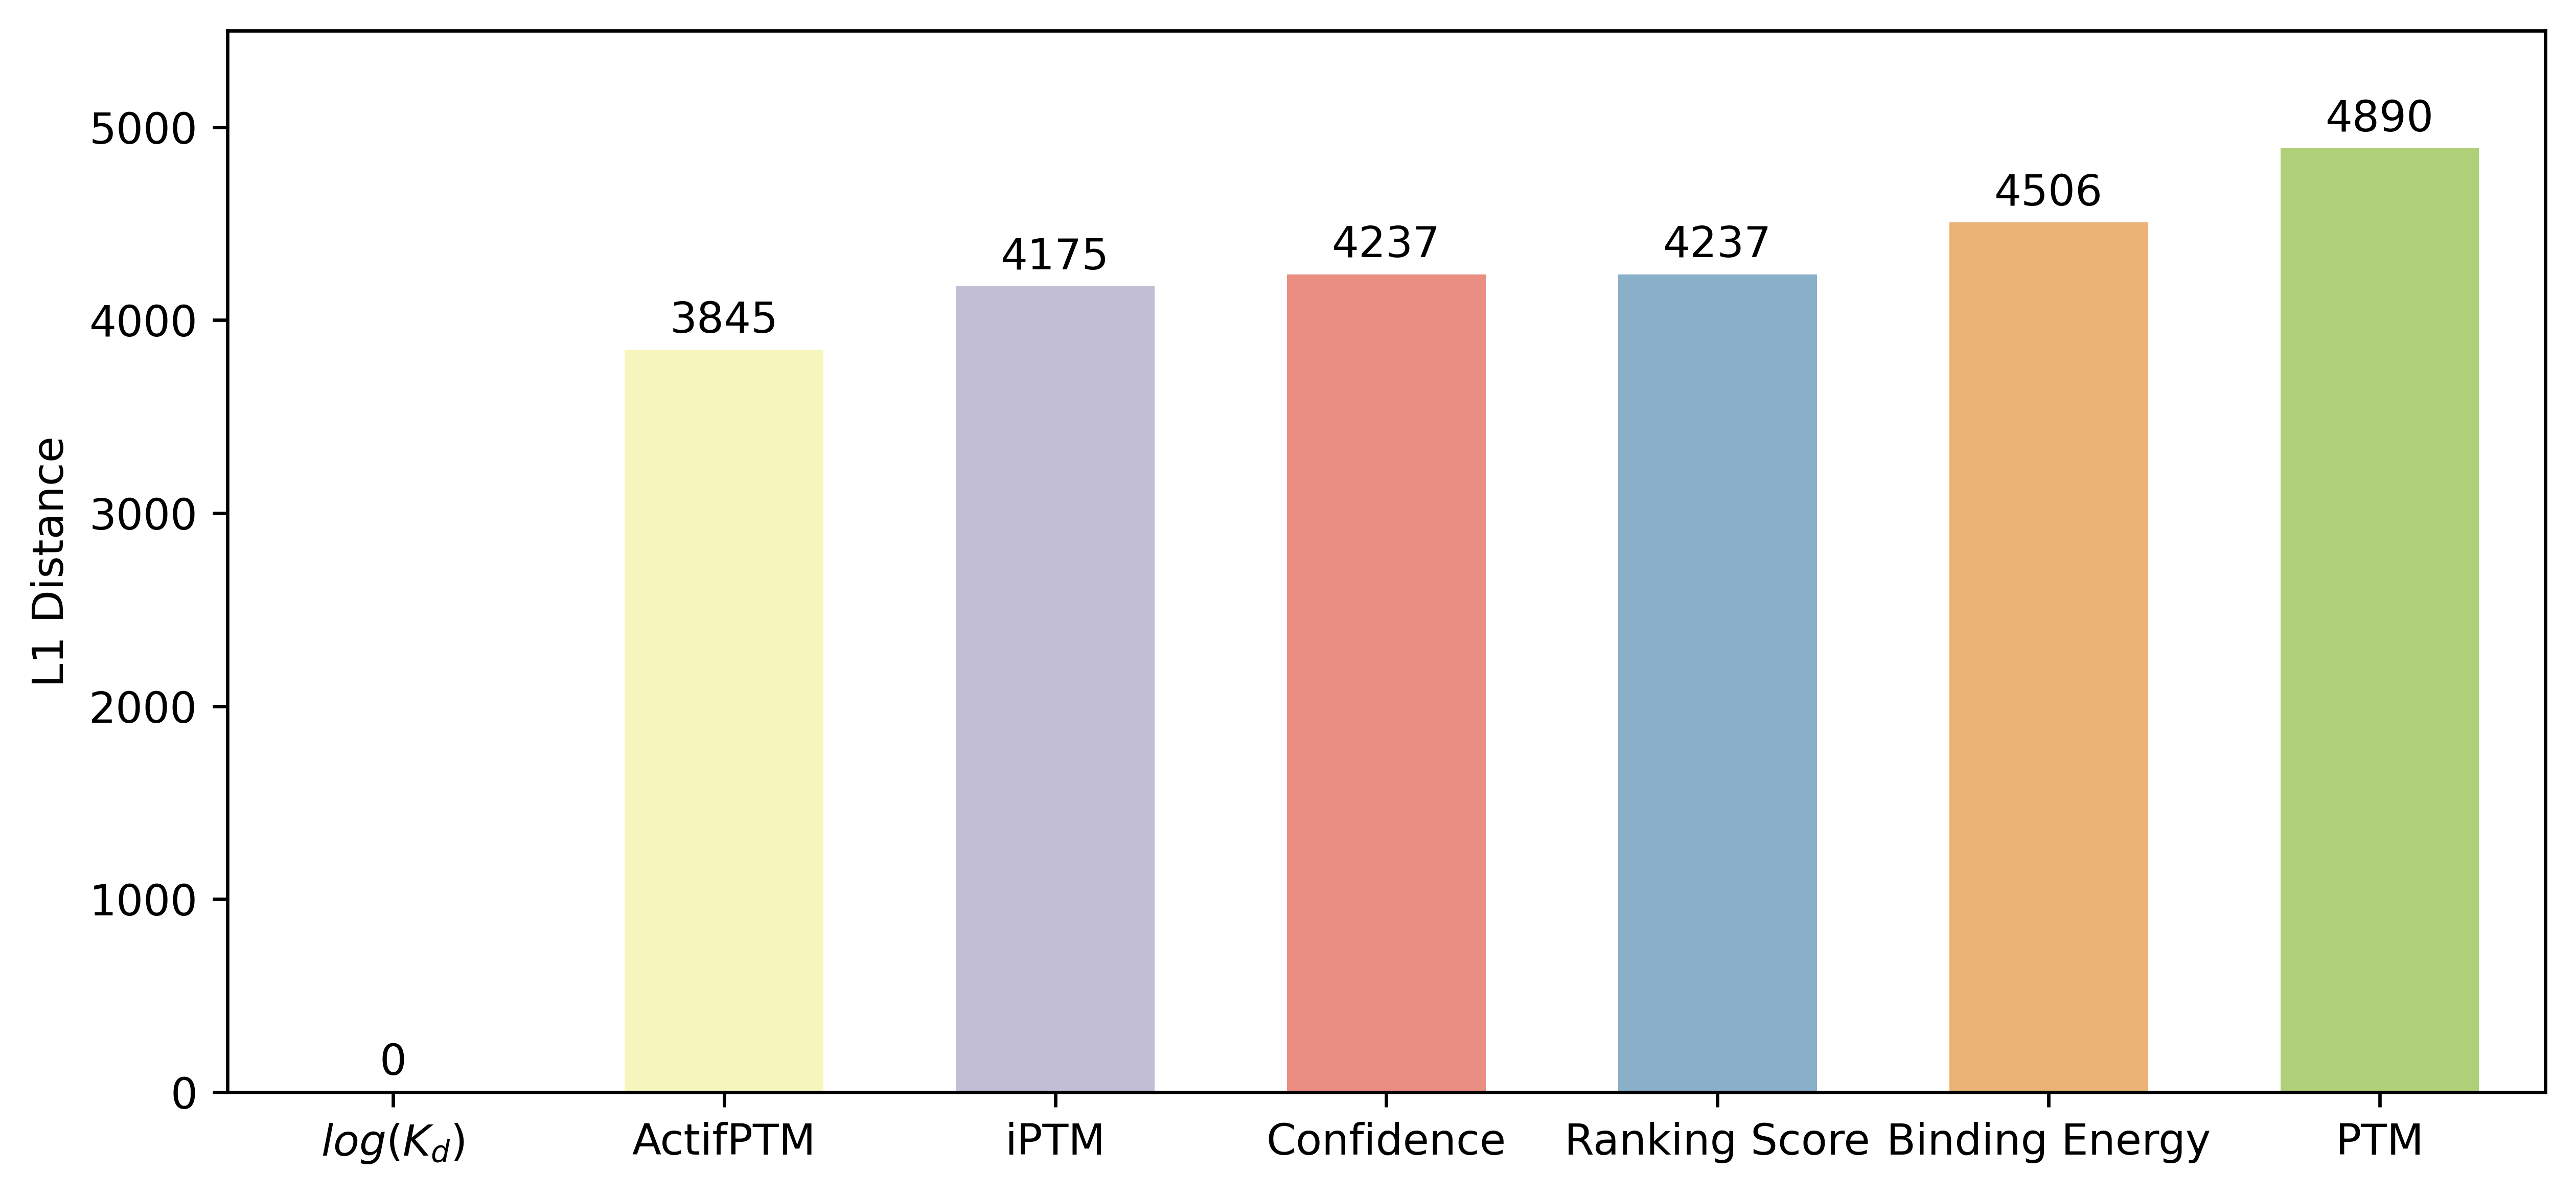

In [466]:
# 选取需要计算排名距离的列
descending_columns = [
    "original_iptm",
    "actifptm",
    "original_ptm",
    "original_confidence_score",
    "original_ranking_score",
]

ascending_columns = ["dG_cross", "meas", "meas_log"]
selected_columns = descending_columns + ascending_columns

# 更友好的标签映射
rename_map = {
    "original_iptm": "iPTM",
    "actifptm": "ActifPTM",
    "original_ptm": "PTM",
    "original_confidence_score": "Confidence",
    "original_ranking_score": "Ranking Score",
    "dG_cross": "Binding Energy",
    "meas": "$K_d$",
    "meas_log": "$log(K_d)$"
}

# 排名
rank_df_ascending = df[ascending_columns].rank(method="average", ascending=True)
rank_df_descending = df[descending_columns].rank(method="average", ascending=False)
rank_df = pd.concat([rank_df_descending, rank_df_ascending], axis=1)

# 计算 L1 距离并排序
l1_distances = np.abs(rank_df.subtract(rank_df["meas"], axis=0)).sum()
l1_distances = l1_distances.drop("meas")
l1_distances = l1_distances.sort_values(ascending=True)  # 👈 排序关键！

# 获取排序后的标签和数值
labels = [rename_map.get(col, col) for col in l1_distances.index]
values = l1_distances.values

# 绘图
plt.figure(figsize=(8.5, 4), dpi=600)
ax = sns.barplot(x=labels, y=values, palette="Set3", width=0.6)

# 数值标签
for container in ax.containers:
    ax.bar_label(container, fmt="%.0f", label_type="edge", padding=2)

ax.set_ylabel("L1 Distance")
ax.set_ylim(0, 5500)
plt.tight_layout()
plt.show()


In [467]:
## Enrichment Factor
def cal_enrichment_factor(df: pd.DataFrame, metric="dG_cross", top_n: int = 20, descending: bool = True) -> float:
    df = df.copy()
    
    # 定义活性分子
    df["is_active"] = df["meas"] < 10
    
    # 总体统计
    total_active = df["is_active"].sum()
    total_mols = len(df)

    if total_active == 0:
        raise ValueError("数据中没有活性分子，无法计算 EF。")
    
    # 排序（按 docking 得分，越小越好）
    df = df.sort_values(by=metric, ascending=descending)  # 更低的dG更好

    # 取 top_n
    top_df = df.head(top_n)
    top_active = top_df["is_active"].sum()
    print(top_active)
    # EF 计算
    ef = (top_active / top_n) / (total_active / total_mols)

    return ef

metrics = ["dG_cross", "meas", "original_ranking_score", "original_iptm", "actifptm", "original_ptm", "original_confidence_score"]
for metric in metrics:
    descending = True if metric in ["dG_cross", "dG_cross_iASA", "meas", "meas_log"] else False
    ef = cal_enrichment_factor(df, metric=metric, top_n=40, descending=descending)
    print(f"{metric}: {ef}")

19
dG_cross: 1.6625
40
meas: 3.5
17
original_ranking_score: 1.4875
24
original_iptm: 2.1
22
actifptm: 1.9250000000000003
14
original_ptm: 1.225
17
original_confidence_score: 1.4875


['$K_d$', 'ActifPTM', 'iPTM', 'Confidence', 'Ranking Score', 'Binding Energy', 'PTM']


/tmp/ipykernel_2393696/1401073634.py:43: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("Set2")


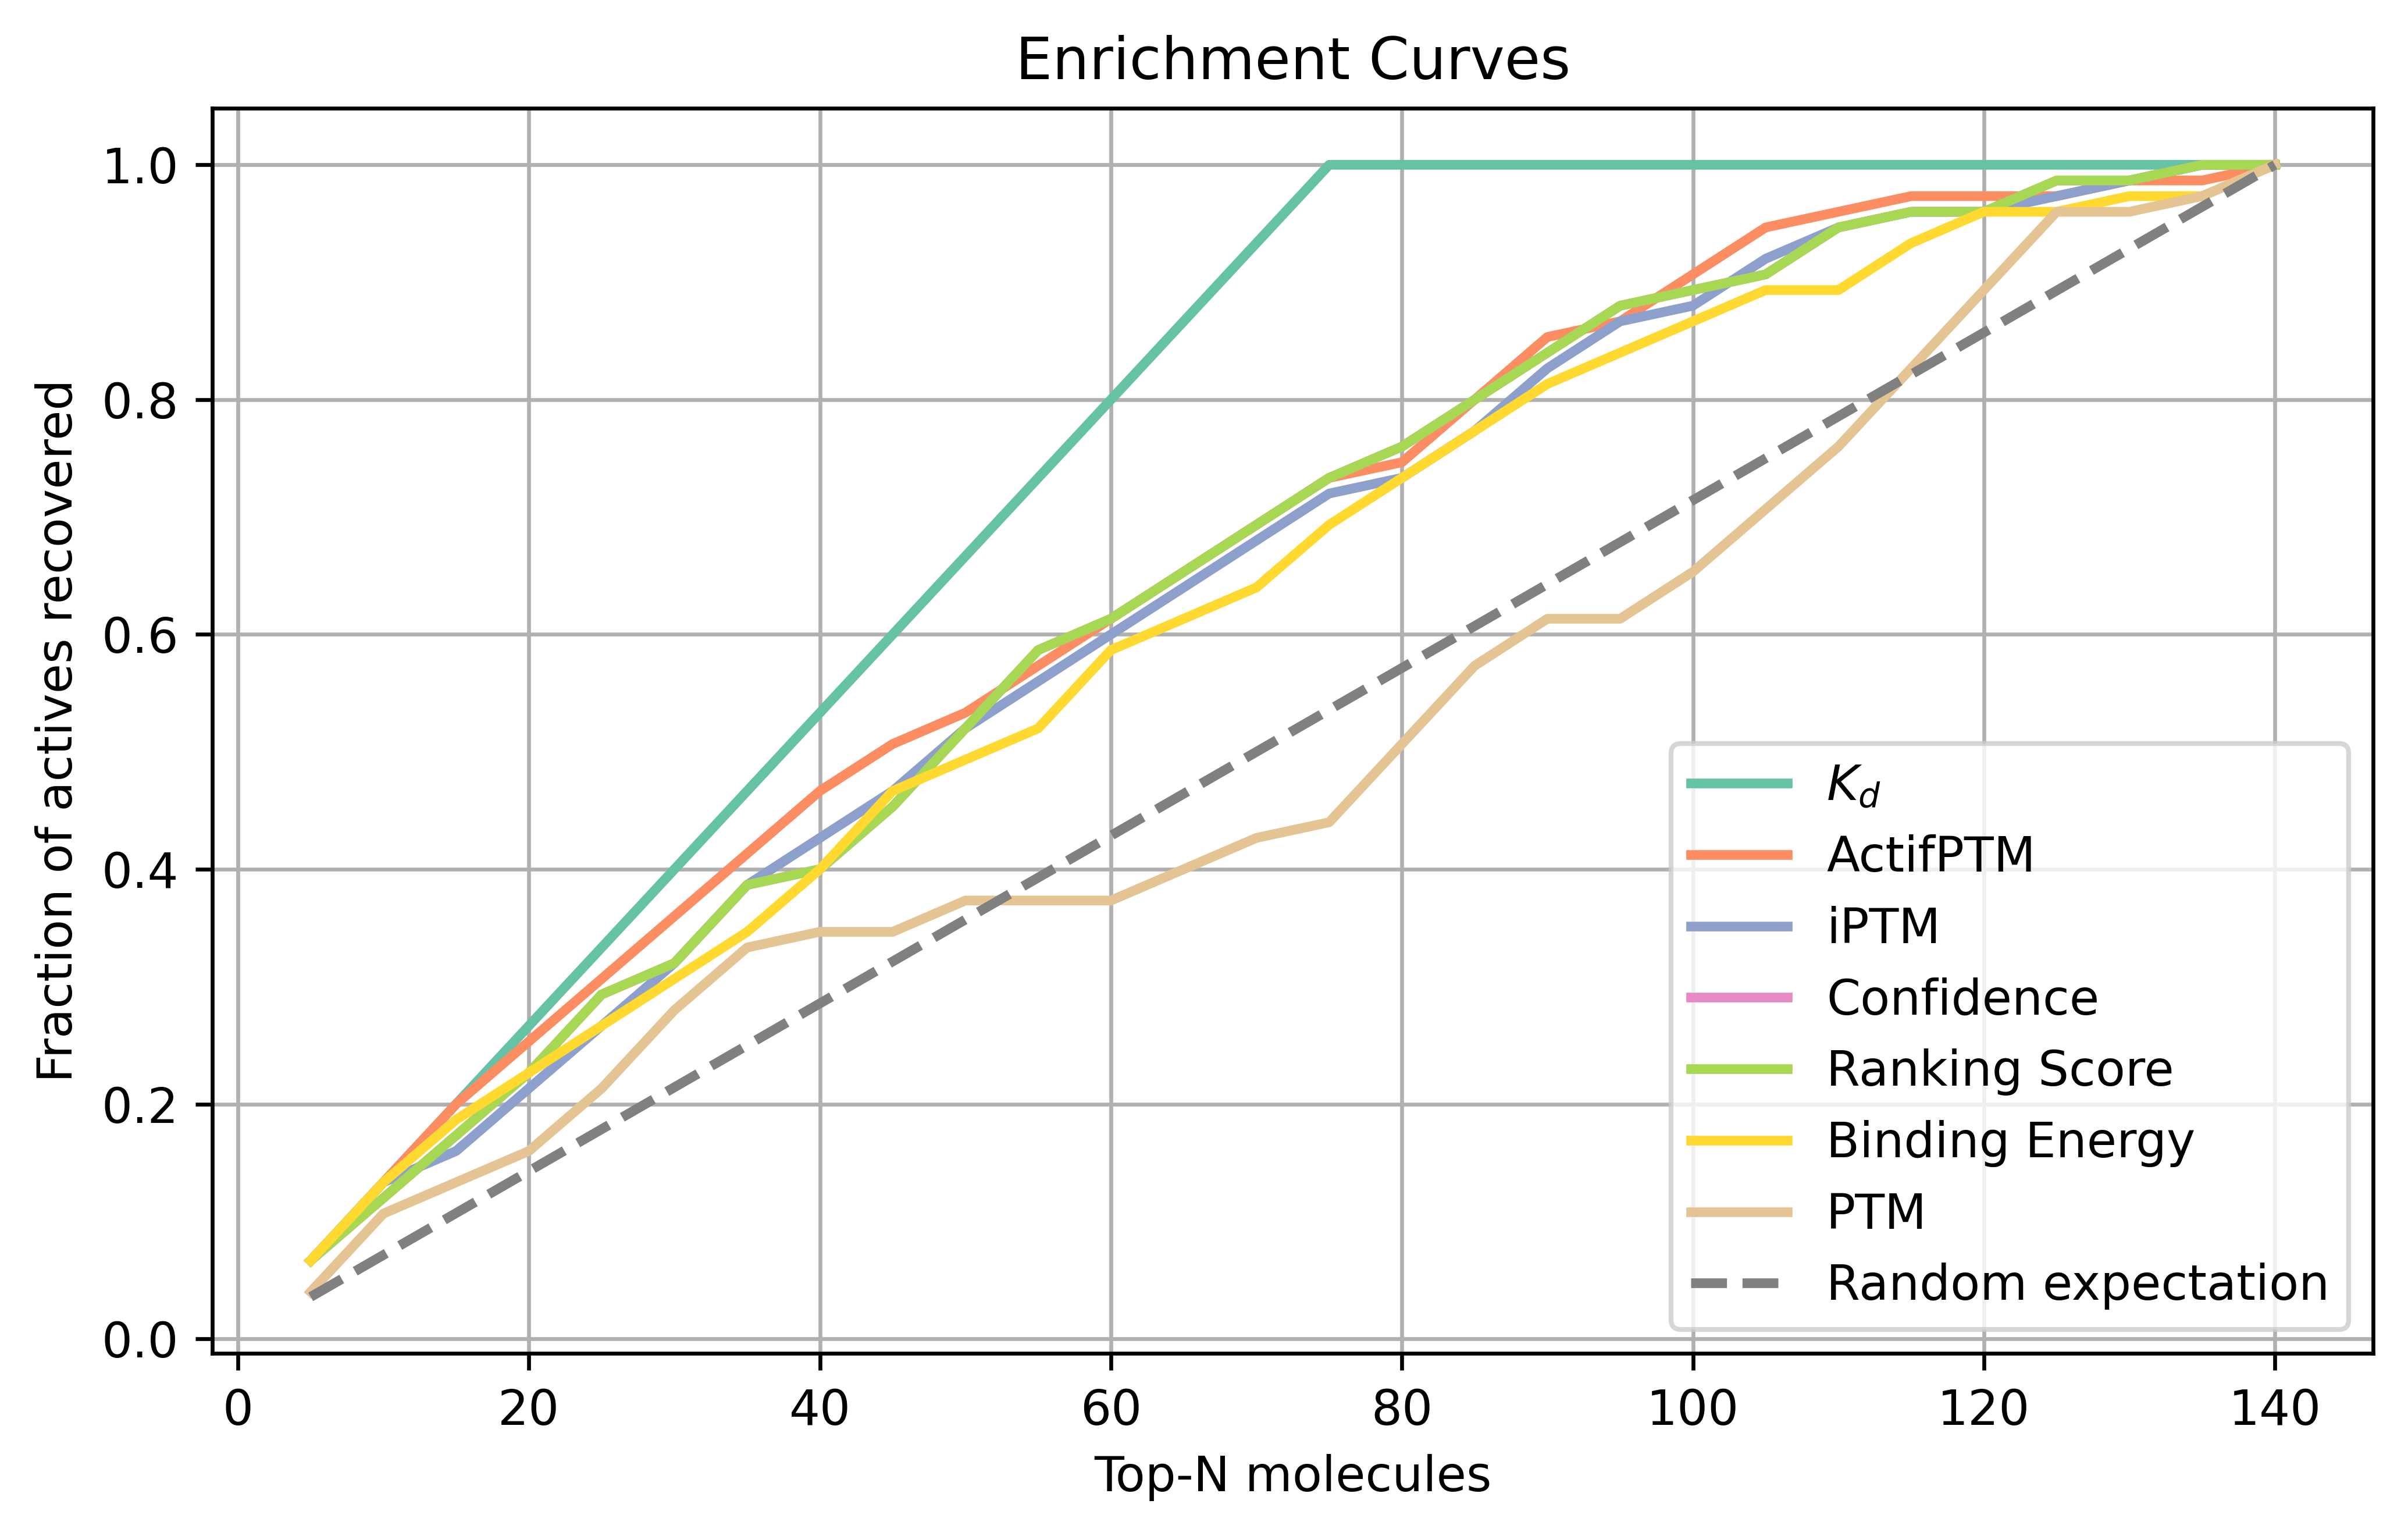

In [470]:
# 希望图例显示顺序
desired_order = [
    "$K_d$",
    "ActifPTM",
    "iPTM",
    "Confidence",
    "Ranking Score",
    "Binding Energy",
    "PTM"
]

def plot_multiple_enrichment_curves(df, metrics, max_n=150):
    df = df.copy()
    df["is_active"] = df["meas"] < 500

    total_active = df["is_active"].sum()
    total_mols = len(df)
    if total_active == 0:
        raise ValueError("没有活性分子，无法绘图")

    top_ns = np.arange(5, min(max_n, total_mols) + 1, 5)
    plt.figure(figsize=(7, 4.5), dpi=600)

    label_to_curve = {}
    metric_to_label = {metric: rename_map.get(metric, metric) for metric in metrics}

    for metric in metrics:
        label = metric_to_label[metric]
        descending = metric in ["dG_cross", "dG_cross_iASA", "meas", "meas_log"]
        df_sorted = df.sort_values(by=metric, ascending=descending)

        enrichments = [
            df_sorted.head(n)["is_active"].sum() / total_active
            for n in top_ns
        ]
        label_to_curve[label] = enrichments

    # 只保留 desired_order 中出现在数据里的项
    labels_to_plot = [label for label in desired_order if label in label_to_curve]
    print(labels_to_plot)

    # 分配颜色
    cmap = cm.get_cmap("Set2")
    colors = [to_hex(cmap(i)) for i in range(len(labels_to_plot))]
    label_to_color = dict(zip(labels_to_plot, colors))

    for label in labels_to_plot:
        plt.plot(top_ns, label_to_curve[label], label=label, color=label_to_color[label], alpha=1, linewidth=2)

    # 随机参考线
    expected = top_ns / total_mols
    plt.plot(top_ns, expected, linestyle='--', color='gray', label="Random expectation", alpha=1, linewidth=2)

    plt.xlabel("Top-N molecules")
    plt.ylabel("Fraction of actives recovered")
    plt.title("Enrichment Curves")

    # 图例按指定顺序排序
    handles, labels = plt.gca().get_legend_handles_labels()
    label_to_handle = dict(zip(labels, handles))
    ordered_labels = [label for label in desired_order if label in label_to_handle] + ["Random expectation"]
    ordered_handles = [label_to_handle[label] for label in ordered_labels]
    plt.legend(ordered_handles, ordered_labels)

    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_multiple_enrichment_curves(df, metrics)

['$K_d$', 'ActifPTM', 'iPTM', 'Confidence', 'Ranking Score', 'Binding Energy', 'PTM']


/tmp/ipykernel_2393696/1908271730.py:43: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("Set2")


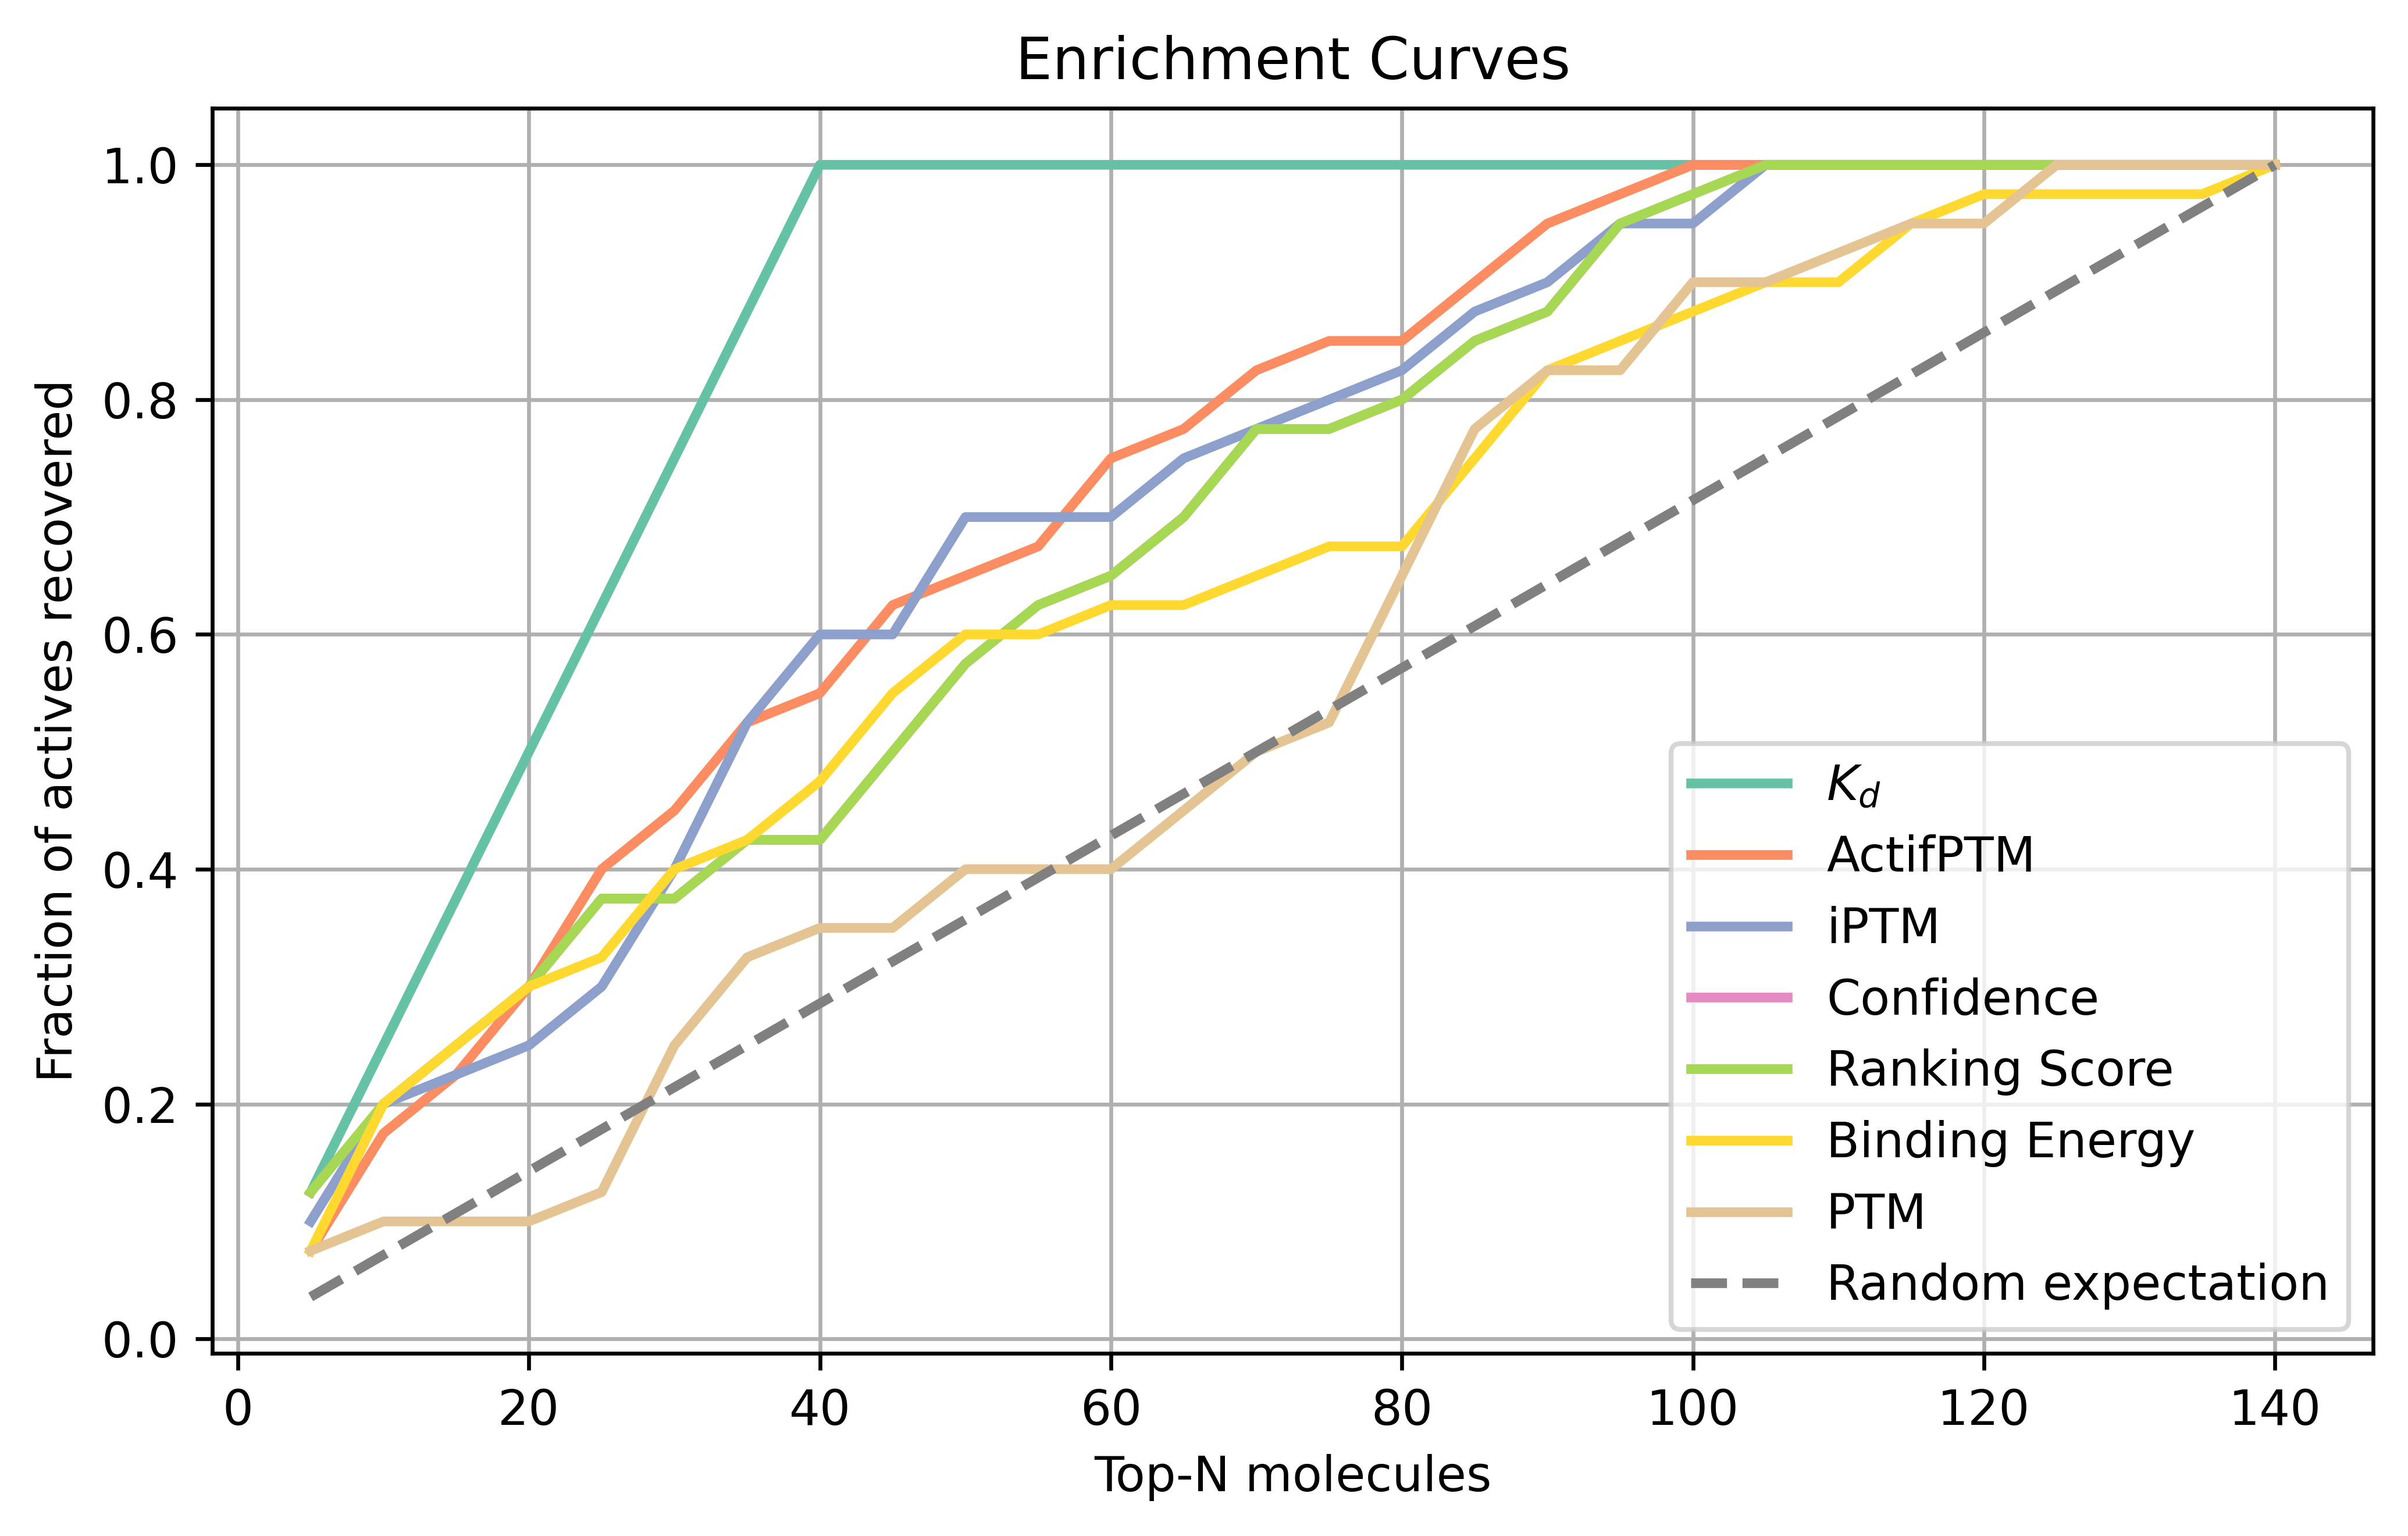

In [471]:
# 希望图例显示顺序
desired_order = [
    "$K_d$",
    "ActifPTM",
    "iPTM",
    "Confidence",
    "Ranking Score",
    "Binding Energy",
    "PTM"
]

def plot_multiple_enrichment_curves(df, metrics, max_n=150):
    df = df.copy()
    df["is_active"] = df["meas"] < 10

    total_active = df["is_active"].sum()
    total_mols = len(df)
    if total_active == 0:
        raise ValueError("没有活性分子，无法绘图")

    top_ns = np.arange(5, min(max_n, total_mols) + 1, 5)
    plt.figure(figsize=(7, 4.5), dpi=600)

    label_to_curve = {}
    metric_to_label = {metric: rename_map.get(metric, metric) for metric in metrics}

    for metric in metrics:
        label = metric_to_label[metric]
        descending = metric in ["dG_cross", "dG_cross_iASA", "meas", "meas_log"]
        df_sorted = df.sort_values(by=metric, ascending=descending)

        enrichments = [
            df_sorted.head(n)["is_active"].sum() / total_active
            for n in top_ns
        ]
        label_to_curve[label] = enrichments

    # 只保留 desired_order 中出现在数据里的项
    labels_to_plot = [label for label in desired_order if label in label_to_curve]
    print(labels_to_plot)

    # 分配颜色
    cmap = cm.get_cmap("Set2")
    colors = [to_hex(cmap(i)) for i in range(len(labels_to_plot))]
    label_to_color = dict(zip(labels_to_plot, colors))

    for label in labels_to_plot:
        plt.plot(top_ns, label_to_curve[label], label=label, color=label_to_color[label], alpha=1, linewidth=2)

    # 随机参考线
    expected = top_ns / total_mols
    plt.plot(top_ns, expected, linestyle='--', color='gray', label="Random expectation", alpha=1, linewidth=2)

    plt.xlabel("Top-N molecules")
    plt.ylabel("Fraction of actives recovered")
    plt.title("Enrichment Curves")

    # 图例按指定顺序排序
    handles, labels = plt.gca().get_legend_handles_labels()
    label_to_handle = dict(zip(labels, handles))
    ordered_labels = [label for label in desired_order if label in label_to_handle] + ["Random expectation"]
    ordered_handles = [label_to_handle[label] for label in ordered_labels]
    plt.legend(ordered_handles, ordered_labels)

    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_multiple_enrichment_curves(df, metrics)